<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/NPML002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np


def logsumexp(log_probs, axis=None):
    """
    计算对数概率的 logsumexp。

    该函数实现了 logsumexp 技巧，用于避免数值下溢。

    参数：
        log_probs: 对数概率数组。
        axis: 沿着哪个轴计算 logsumexp，默认为 None，表示计算所有元素的 logsumexp。

    返回值：
        对数概率的 logsumexp。

    思路：
        logsumexp 技巧的公式为：
        log(sum(exp(x_i))) = max(x_i) + log(sum(exp(x_i - max(x_i))))
        通过减去最大值，可以避免 exp(x_i) 出现数值上溢，从而提高计算精度。
    """
    _max = np.max(log_probs)  # 找到最大值
    ds = log_probs - _max  # 减去最大值
    exp_sum = np.exp(ds).sum(axis=axis)  # 计算 exp 的和
    return _max + np.log(exp_sum)  # 加回最大值



def log_gaussian_pdf(x_i, mu, sigma):
    """
    计算多元高斯分布的对数概率密度函数。

    参数：
        x_i: 数据点，形状为 (d,)，其中 d 是数据点的维度。
        mu: 均值向量，形状为 (d,)。
        sigma: 协方差矩阵，形状为 (d, d)。

    返回值：
        数据点 x_i 在多元高斯分布下的对数概率密度。

    思路：
        多元高斯分布的对数概率密度函数公式为：
        log N(x_i | mu, sigma) = -0.5 * (d * log(2 * pi) + log(det(sigma)) + (x_i - mu)^T * sigma^-1 * (x_i - mu))
        其中 d 是数据点的维度，det(sigma) 是协方差矩阵的行列式，sigma^-1 是协方差矩阵的逆矩阵。
        为了避免数值问题，可以使用 `slogdet` 函数计算协方差矩阵的行列式的对数，
        使用 `solve` 函数计算协方差矩阵的逆矩阵与向量的乘积。
    """
    n = len(mu)  # 数据点的维度
    det_sigma = np.linalg.det(sigma)  # 计算协方差矩阵的行列式

    # 如果协方差矩阵奇异，返回负无穷
    if det_sigma == 0:
        return -np.inf

    inv_sigma = np.linalg.inv(sigma)  # 计算协方差矩阵的逆矩阵

    # 计算 (x_i - mu)^T * sigma^-1 * (x_i - mu)
    diff = x_i - mu
    exponent = -0.5 * diff.T @ inv_sigma @ diff

    # 计算对数似然值
    log_likelihood = -0.5 * (n * np.log(2 * np.pi) + np.log(det_sigma)) + exponent

    return log_likelihood


class MultinomialHMM:
    """
    一个简单的隐马尔可夫模型，具有多项式发射分布。

    参数：
        A: 状态转移矩阵，形状为 (N, N)。
        B: 发射矩阵，形状为 (N, V)。
        pi: 初始状态概率分布，形状为 (N,)。
        eps: 防止出现 log(0) 错误的极小值。

    属性：
        A: 状态转移矩阵。
        B: 发射矩阵。
        N: 隐状态的数量。
        V: 观察状态的数量。
        O: 观察序列的集合。
        I: 观察序列的数量。
        T: 每个观察序列的长度。
    """
    def __init__(self, A=None, B=None, pi=None, eps=None):
        eps = np.finfo(float).eps if eps is None else eps

        # 初始化初始状态概率分布
        if pi is not None:
            pi[pi == 0] = eps

        # 获取隐状态的数量
        N = None
        if A is not None:
            N = A.shape[0]
            A[A == 0] = eps

        # 获取观察状态的数量
        V = None
        if B is not None:
            V = B.shape[1]
            B[B == 0] = eps

        self.parameters = {
            "A": A,  # 状态转移矩阵
            "B": B,  # 发射矩阵
            "pi": pi,  # 初始状态概率分布
        }

        self.hyperparameters = {
            "eps": eps,  # 极小值
        }

        self.derived_variables = {
            "N": N,  # 隐状态的数量
            "V": V,  # 观察状态的数量
        }

#    def generate(self, n_steps, latent_state_types, obs_types):
#        """
#        从隐马尔可夫模型中采样一个序列。
#
#        参数：
#            n_steps: 生成的序列长度。
#            latent_state_types: 隐状态类型的集合。
#            obs_types: 观察状态类型的集合。
#
#        返回值：
#            states: 采样的隐状态序列。
#            emissions: 采样的观察状态序列。
#        """
#        P = self.parameters
#        A, B, pi = P["A"], P["B"], P["pi"]
#
#        # 采样初始隐状态
#        s = np.random.multinomial(1, pi).argmax()
#        states = [latent_state_types[s]]
#
#        # 根据隐状态生成观察状态
#        v = np.random.multinomial(1, B[s, :]).argmax()
#        emissions = [obs_types[v]]
#
#        # 采样隐状态转移，并重复生成观察状态
#        for i in range(n_steps - 1):
#            s = np.random.multinomial(1, A[s, :]).argmax()
#            states.append(latent_state_types[s])
#
#            v = np.random.multinomial(1, B[s, :]).argmax()
#            emissions.append(obs_types[v])
#
#        return np.array(states), np.array(emissions)

    def generate(self, n_steps, latent_state_types, obs_types):
            """
            从隐马尔可夫模型中采样一个序列。

            参数：
                n_steps: 生成的序列长度。
                latent_state_types: 隐状态类型的集合。
                obs_types: 观察状态类型的集合。

            返回值：
                states: 采样的隐状态序列。
                emissions: 采样的观察状态序列。
            """
            P = self.parameters
            A, B, pi = P["A"], P["B"], P["pi"]

            # 采样初始隐状态
            # 检查 pi 是否有效，并进行修正
            if not np.isclose(np.sum(pi), 1.0) or np.any(pi < 0) or np.any(pi > 1):
                pi = np.clip(pi, np.finfo(float).eps, 1 - np.finfo(float).eps) # 将概率限制在 (0, 1) 范围内
                pi /= np.sum(pi)  # 重新归一化，确保概率之和为 1

            s = np.random.multinomial(1, pi).argmax()
            states = [latent_state_types[s]]

            # 根据隐状态生成观察状态
            v = np.random.multinomial(1, B[s, :]).argmax()
            emissions = [obs_types[v]]

            # 采样隐状态转移，并重复生成观察状态
            for i in range(n_steps - 1):
                s = np.random.multinomial(1, A[s, :]).argmax()
                states.append(latent_state_types[s])

                v = np.random.multinomial(1, B[s, :]).argmax()
                emissions.append(obs_types[v])

            return np.array(states), np.array(emissions)


    def log_likelihood(self, O):
        """
        计算观察序列 O 的边际似然度。

        参数：
            O: 观察序列。

        返回值：
            观察序列 O 的似然度。
        """
        if O.ndim == 1:
            O = O.reshape(1, -1)

        I, T = O.shape

        if I != 1:
            raise ValueError("似然度计算只接受单个序列")

        forward = self._forward(O[0])
        log_likelihood = logsumexp(forward[:, T - 1])
        return log_likelihood

    def decode(self, O):
        """
        使用维特比算法解码观察序列 O，找到最可能的隐状态序列。

        参数：
            O: 观察序列。

        返回值：
            best_path: 最可能的隐状态序列。
            best_path_prob: 最可能的隐状态序列的概率。
        """
        P = self.parameters
        N = self.derived_variables["N"]
        eps = self.hyperparameters["eps"]
        A, B, pi = P["A"], P["B"], P["pi"]

        if O.ndim == 1:
            O = O.reshape(1, -1)

        # 观察序列的长度
        T = O.shape[1]

        # 训练序列的数量
        I = O.shape[0]
        if I != 1:
            raise ValueError("只能解码单个序列 (O.shape[0] 必须为 1)")

        # 初始化维特比矩阵和回溯指针矩阵
        viterbi = np.zeros((N, T))
        back_pointer = np.zeros((N, T)).astype(int)

        ot = O[0, 0]
        for s in range(N):
            back_pointer[s, 0] = 0
            viterbi[s, 0] = np.log(pi[s] + eps) + np.log(B[s, ot] + eps)

        for t in range(1, T):
            ot = O[0, t]
            for s in range(N):
                seq_probs = [
                    viterbi[s_, t - 1] + np.log(A[s_, s] + eps) + np.log(B[s, ot] + eps)
                    for s_ in range(N)
                ]

                viterbi[s, t] = np.max(seq_probs)
                back_pointer[s, t] = np.argmax(seq_probs)

        best_path_log_prob = viterbi[:, T - 1].max()

        # 回溯找到最可能的隐状态序列
        pointer = viterbi[:, T - 1].argmax()
        best_path = [pointer]
        for t in reversed(range(1, T)):
            pointer = back_pointer[pointer, t]
            best_path.append(pointer)
        best_path = best_path[::-1]

        return best_path, best_path_log_prob

    def _forward(self, Obs):
        """
        计算前向概率矩阵。

        参数：
            Obs: 观察序列。

        返回值：
            forward: 前向概率矩阵。
        """
        P = self.parameters
        N = self.derived_variables["N"]
        eps = self.hyperparameters["eps"]
        A, B, pi = P["A"], P["B"], P["pi"]

        T = Obs.shape[0]

        # 初始化前向概率矩阵
        forward = np.zeros((N, T))

        ot = Obs[0]
        for s in range(N):
            forward[s, 0] = np.log(pi[s] + eps) + np.log(B[s, ot] + eps)

        for t in range(1, T):
            ot = Obs[t]
            for s in range(N):
                forward[s, t] = logsumexp(
                    [
                        forward[s_, t - 1]
                        + np.log(A[s_, s] + eps)
                        + np.log(B[s, ot] + eps)
                        for s_ in range(N)
                    ]
                )
        return forward

    def _backward(self, Obs):
        """
        计算后向概率矩阵。

        参数：
            Obs: 观察序列。

        返回值：
            backward: 后向概率矩阵。
        """
        P = self.parameters
        A, B = P["A"], P["B"]
        N = self.derived_variables["N"]
        eps = self.hyperparameters["eps"]

        T = Obs.shape[0]

        # 初始化后向概率矩阵
        backward = np.zeros((N, T))

        for s in range(N):
            backward[s, T - 1] = 0

        for t in reversed(range(T - 1)):
            ot1 = Obs[t + 1]
            for s in range(N):
                backward[s, t] = logsumexp(
                    [
                        np.log(A[s, s_] + eps)
                        + np.log(B[s_, ot1] + eps)
                        + backward[s_, t + 1]
                        for s_ in range(N)
                    ]
                )
        return backward

    def _initialize_parameters(self):
        """
        初始化模型参数。
        """
        P = self.parameters
        A, B, pi = P["A"], P["B"], P["pi"]
        N, V = self.derived_variables["N"], self.derived_variables["V"]

        # 初始化初始状态概率分布
        if pi is None:
            pi = np.ones(N)
            pi = pi / pi.sum()

        # 初始化状态转移矩阵
        if A is None:
            A = np.ones((N, N))
            A = A / A.sum(axis=1)[:, None]

        # 初始化发射矩阵
        if B is None:
            B = np.random.rand(N, V)
            B = B / B.sum(axis=1)[:, None]

        P["A"], P["B"], P["pi"] = A, B, pi

    def fit(
        self,
        O,
        latent_state_types,
        observation_types,
        pi=None,
        tol=1e-5,
        verbose=False,
    ):
        """
        使用 Baum-Welch 算法训练隐马尔可夫模型。

        参数：
            O: 观察序列的集合。
            latent_state_types: 隐状态类型的集合。
            observation_types: 观察状态类型的集合。
            pi: 初始状态概率分布，默认为 None。
            tol: 停止训练的阈值，默认为 1e-5。
            verbose: 是否打印训练信息，默认为 False。
        """
        # 观察序列
        if O.ndim == 1:
            O = O.reshape(1, -1)

        # 训练样本数量和序列长度
        I, T = O.shape

        # 观察状态类型数量
        self.derived_variables["V"] = len(observation_types)

        # 隐状态类型数量
        self.derived_variables["N"] = len(latent_state_types)

        self._initialize_parameters()

        P = self.parameters

        # 迭代 E 步和 M 步，直到收敛
        step, delta = 0, np.inf
        ll_prev = np.sum([self.log_likelihood(o) for o in O])

        while delta > tol:
            gamma, xi, phi = self._E_step(O)
            P["A"], P["B"], P["pi"] = self._M_step(O, gamma, xi, phi)
            ll = np.sum([self.log_likelihood(o) for o in O])
            delta = ll - ll_prev
            ll_prev = ll
            step += 1

            if verbose:
                fstr = "[Epoch {}] LL: {:.3f} Delta: {:.5f}"
                print(fstr.format(step, ll_prev, delta))


    def _E_step(self, O):
        """
        执行 Baum-Welch 算法的 E 步。

        参数：
            O: 观察序列的集合。

        返回值：
            gamma: 状态占据概率矩阵。
            xi: 状态转移概率矩阵。
            phi: 初始状态概率矩阵。
        """
        I, T = O.shape
        P = self.parameters
        A, B = P["A"], P["B"]
        N = self.derived_variables["N"]
        eps = self.hyperparameters["eps"]

        phi = np.zeros((I, N))
        gamma = np.zeros((I, N, T))
        xi = np.zeros((I, N, N, T))

        for i in range(I):
            Obs = O[i, :]
            fwd = self._forward(Obs)
            bwd = self._backward(Obs)
            log_likelihood = logsumexp(fwd[:, T - 1])

            t = T - 1
            for si in range(N):
                gamma[i, si, t] = fwd[si, t] + bwd[si, t] - log_likelihood
                phi[i, si] = fwd[si, 0] + bwd[si, 0] - log_likelihood

            for t in range(T - 1):
                ot1 = Obs[t + 1]
                for si in range(N):
                    gamma[i, si, t] = fwd[si, t] + bwd[si, t] - log_likelihood
                    for sj in range(N):
                        xi[i, si, sj, t] = (
                            fwd[si, t]
                            + np.log(A[si, sj] + eps)
                            + np.log(B[sj, ot1] + eps)
                            + bwd[sj, t + 1]
                            - log_likelihood
                        )

        return gamma, xi, phi

    def _M_step(self, O, gamma, xi, phi):
        """
        执行 Baum-Welch 算法的 M 步。

        参数：
            O: 观察序列的集合。
            gamma: 状态占据概率矩阵。
            xi: 状态转移概率矩阵。
            phi: 初始状态概率矩阵。

        返回值：
            A: 更新后的状态转移矩阵。
            B: 更新后的发射矩阵。
            pi: 更新后的初始状态概率分布。
        """
        I, T = O.shape
        P = self.parameters
        DV = self.derived_variables
        eps = self.hyperparameters["eps"]

        N, V = DV["N"], DV["V"]
        A, B, pi = P["A"], P["B"], P["pi"]

        # 初始化状态转移矩阵、发射矩阵和初始状态概率分布
        A = np.zeros((N, N))
        B = np.zeros((N, V))
        pi = np.zeros(N)

        count_gamma = np.zeros((I, N, V))
        count_xi = np.zeros((I, N, N))

        for i in range(I):
            Obs = O[i, :]
            for si in range(N):
                for vk in range(V):
                    if not (Obs == vk).any():
                        count_gamma[i, si, vk] = np.log(eps)
                    else:
                        count_gamma[i, si, vk] = logsumexp(gamma[i, si, Obs == vk])

                for sj in range(N):
                    count_xi[i, si, sj] = logsumexp(xi[i, si, sj, :])

        pi = logsumexp(phi, axis=0) - np.log(I + eps)
        np.testing.assert_almost_equal(np.exp(pi).sum(), 1)

        for si in range(N):
            for vk in range(V):
                B[si, vk] = logsumexp(count_gamma[:, si, vk]) - logsumexp(
                    count_gamma[:, si, :]
                )

            for sj in range(N):
                A[si, sj] = logsumexp(count_xi[:, si, sj]) - logsumexp(
                    count_xi[:, si, :]
                )

            np.testing.assert_almost_equal(np.exp(A[si, :]).sum(), 1)
            np.testing.assert_almost_equal(np.exp(B[si, :]).sum(), 1)
        return np.exp(A), np.exp(B), np.exp(pi)

In [2]:
import numpy as np

# 假设有两个隐状态（'Rainy', 'Sunny'）和三个观察状态（'walk', 'shop', 'clean'）
latent_state_types = ['Rainy', 'Sunny']
observation_types = ['walk', 'shop', 'clean']

# 定义状态转移矩阵 A，发射矩阵 B 和初始状态概率分布 pi
A = np.array([[0.7, 0.3], [0.4, 0.6]])  # 状态转移矩阵
B = np.array([[0.1, 0.4, 0.5], [0.6, 0.3, 0.1]])  # 发射矩阵
pi = np.array([0.6, 0.4])  # 初始状态概率分布

# 创建 MultinomialHMM 实例
model = MultinomialHMM(A, B, pi)

# 生成一个观察序列
O = np.array([0, 1, 2, 0, 1])  # 对应观察状态 'walk', 'shop', 'clean', 'walk', 'shop'

# 使用模型解码观察序列，得到最可能的隐状态序列
best_path, best_path_prob = model.decode(O)

# 打印结果
print("最可能的隐状态序列：", [latent_state_types[state] for state in best_path])
print("最可能的隐状态序列的概率：", best_path_prob)

# 使用模型生成一个新的观察序列和隐状态序列
states, emissions = model.generate(5, latent_state_types, observation_types)

# 打印结果
print("生成的隐状态序列：", states)
print("生成的观察状态序列：", emissions)

最可能的隐状态序列： ['Sunny', 'Rainy', 'Rainy', 'Sunny', 'Sunny']
最可能的隐状态序列的概率： -7.739116800070981
生成的隐状态序列： ['Rainy' 'Rainy' 'Sunny' 'Rainy' 'Sunny']
生成的观察状态序列： ['clean' 'clean' 'walk' 'walk' 'walk']



*任务*： 开发一个能够根据用户输入的文本，自动识别文本中表达的情感倾向的程序。

*难度*：

* 需要处理复杂的语法结构和语义关系。
* 需要理解自然语言的歧义性。
* 需要处理不同语言和文化背景下的情感表达方式。

*解决方案*： 可以使用自然语言处理（NLP）和机器学习（ML）技术来解决此问题。以下是一个可能的解决方案步骤：

1. 数据收集和预处理：
* 收集大量带情感标签的文本数据，例如电影评论、产品评价、社交媒体帖子等。
* 对文本数据进行预处理，包括分词、词干提取、停用词去除等。

2. 特征工程：
* 从文本数据中提取情感相关的特征，例如情感词、情感短语、语法结构、语义角色等。
* 可以使用词嵌入技术将文本转换为向量表示，以便机器学习模型处理。

3. 模型训练：
* 使用机器学习算法，例如支持向量机（SVM）、朴素贝叶斯（NB）、深度学习模型（如循环神经网络 RNN）等，对带情感标签的文本数据进行训练。

4. 模型评估和优化：
* 使用测试集评估模型的性能，例如准确率、召回率、F1 值等。
* 根据评估结果优化模型参数和特征工程方法。

5. 应用部署：
* 将训练好的模型部署到实际应用中，例如情感分析API、舆情监控系统、智能客服等。

*复杂性分析*：
* 此任务涉及到自然语言理解、机器学习、数据挖掘等多个领域的技术。
* 需要处理大量的文本数据，并进行复杂的特征工程。
* 需要选择合适的机器学习模型，并进行参数优化。
* 需要考虑实际应用场景，并进行模型部署和维护。

*应用场景*：
* 舆情监控：分析社交媒体、新闻报道等文本数据，了解公众对特定事件或话题的情感倾向。
* 市场调研：分析消费者对产品或服务的评价，了解产品的优势和劣势。
* 智能客服：根据用户输入的文本，识别用户的情感状态，并提供更人性化的服务。

In [3]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# 下载情感分析模型
nltk.download('vader_lexicon')

# 创建情感分析器
analyzer = SentimentIntensityAnalyzer()

# 待分析的文本
text = "I love this product! It is amazing."

# 进行情感分析
scores = analyzer.polarity_scores(text)

# 打印结果
print(scores)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


{'neg': 0.0, 'neu': 0.325, 'pos': 0.675, 'compound': 0.8516}


In [4]:
import numpy as np
#from MultinomialHMM import MultinomialHMM

# 定义隐状态类型（情感标签）和观察状态类型（单词）
latent_state_types = ['positive', 'negative', 'neutral']
observation_types = ['good', 'bad', 'happy', 'sad', 'ok']

# 准备训练数据
# 使用一个简单的示例数据集
training_data = [
    ('good happy', 'positive'),
    ('bad sad', 'negative'),
    ('ok', 'neutral'),
    ('good ok', 'positive'),
    ('bad happy', 'negative'),  # 引入一些噪声
]

# 将训练数据转换为观察序列和隐状态序列
O = []
S = []
for text, label in training_data:
    obs_seq = [observation_types.index(word) for word in text.split()]
    O.append(np.array(obs_seq))
    S.append(latent_state_types.index(label))

# 创建 MultinomialHMM 实例
model = MultinomialHMM()

#  将 O 转换为一个统一形状的数组，使用padding
max_len = max(len(obs) for obs in O) # 获取最长序列的长度
padded_O = np.zeros((len(O), max_len), dtype=int)  # 创建一个填充数组

for i, obs in enumerate(O):
    padded_O[i, :len(obs)] = obs # 将每个序列复制到填充数组中

# 训练模型，使用填充后的数组
model.fit(padded_O, latent_state_types, observation_types)

# 对新的文本进行情感分类
def classify_text(text):
    obs_seq = np.array([observation_types.index(word) for word in text.split() if word in observation_types])
    if len(obs_seq) == 0:
        return "unknown"  # 处理未知单词的情况
    best_path, best_path_prob = model.decode(obs_seq)
    predicted_label = latent_state_types[best_path[-1]]
    return predicted_label

# 测试情感分类功能
test_texts = ['good happy', 'bad sad', 'ok', 'good bad', 'happy sad']
for text in test_texts:
    predicted_label = classify_text(text)
    print(f"Text: {text}, Predicted label: {predicted_label}")

# 生成新的文本
generated_states, generated_emissions = model.generate(5, latent_state_types, observation_types)
generated_text = ' '.join(generated_emissions)
print(f"Generated text: {generated_text}")

# 计算对数似然度
log_likelihood = model.log_likelihood(O[0])  # 计算第一个训练样本的对数似然度
print(f"Log likelihood of the first training sample: {log_likelihood}")

# 评估模型性能 (简单的准确率计算)
correct_predictions = 0
for text, label in training_data:
    predicted_label = classify_text(text)
    if predicted_label == label:
        correct_predictions += 1
accuracy = correct_predictions / len(training_data)
print(f"Accuracy on training data: {accuracy}")

Text: good happy, Predicted label: positive
Text: bad sad, Predicted label: negative
Text: ok, Predicted label: neutral
Text: good bad, Predicted label: neutral
Text: happy sad, Predicted label: negative
Generated text: bad happy ok bad happy
Log likelihood of the first training sample: -1.8474354566537976
Accuracy on training data: 0.6


In [5]:
import graphviz
from IPython.display import Image

def visualize_hmm(model, latent_state_types, observation_types, filename="hmm_visualization"):
    """
    可视化 MultinomialHMM 的结构和参数。

    参数：
        model: 训练好的 MultinomialHMM 实例。
        latent_state_types: 隐状态类型列表（例如，['积极', '消极']）。
        observation_types: 观察状态类型列表（例如，['好', '坏']）。
        filename: 输出文件名（不带扩展名）。
    """

    dot = graphviz.Digraph(comment='隐马尔可夫模型可视化')

    # 为隐状态添加节点
    for state in latent_state_types:
        dot.node(state, label=state)

    # 为状态转移添加边，并标注概率
    A = model.parameters["A"]  # 状态转移矩阵
    for i, from_state in enumerate(latent_state_types):
        for j, to_state in enumerate(latent_state_types):
            prob = A[i, j]
            if prob > 0.01:  # 显示阈值
                dot.edge(from_state, to_state, label=f"{prob:.2f}")

    # 将发射概率作为节点标签添加
    B = model.parameters["B"]  # 发射矩阵
    for i, state in enumerate(latent_state_types):
        emissions = [f"{obs}: {prob:.2f}" for obs, prob in zip(observation_types, B[i]) if prob > 0.01]
        dot.node(state, label=f"{state}\n({', '.join(emissions)})")

    # 渲染图形
    dot.render(filename, format='png', view=False)
    return Image(filename=filename + ".png")

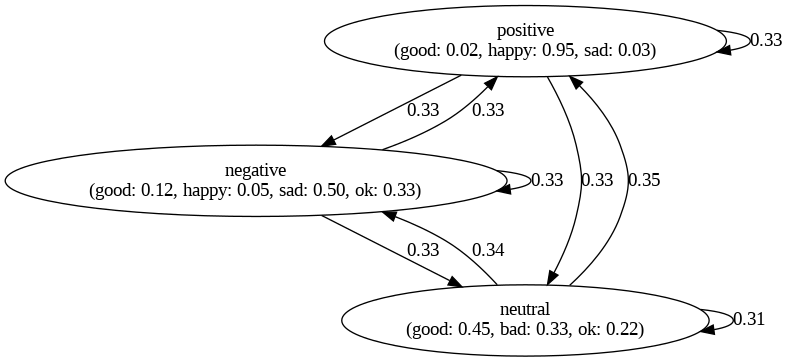

In [6]:
import numpy as np
import graphviz

# 使用 visualize_hmm 函数可视化模型
display(visualize_hmm(model, latent_state_types, observation_types, filename="my_hmm_visualization"))

In [7]:

mini_library = '''
*** START OF THE PROJECT GUTENBERG EBOOK MACBETH ***

Turn, hell-hound, turn!


Of all men else I have avoided thee:
But get thee back; my soul is too much charg’d
With blood of thine already.


I have no words;
My voice is in my sword: thou bloodier villain
Than terms can give thee out!

Thou losest labour:
As easy mayst thou the intrenchant air
With thy keen sword impress, as make me bleed:
Let fall thy blade on vulnerable crests;
I bear a charmed life, which must not yield
To one of woman born.


Despair thy charm;
And let the angel whom thou still hast serv’d
Tell thee, Macduff was from his mother’s womb
Untimely ripp’d.


Accursed be that tongue that tells me so,
For it hath cow’d my better part of man!
And be these juggling fiends no more believ’d,
That palter with us in a double sense;
That keep the word of promise to our ear,
And break it to our hope!—I’ll not fight with thee.


Then yield thee, coward,
And live to be the show and gaze o’ th’ time.
We’ll have thee, as our rarer monsters are,
Painted upon a pole, and underwrit,
“Here may you see the tyrant.”


I will not yield,
To kiss the ground before young Malcolm’s feet,
And to be baited with the rabble’s curse.
Though Birnam wood be come to Dunsinane,
And thou oppos’d, being of no woman born,
Yet I will try the last. Before my body
I throw my warlike shield: lay on, Macduff;
And damn’d be him that first cries, “Hold, enough!”


*** END OF THE PROJECT GUTENBERG EBOOK MACBETH ***

 '''

In [8]:
!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

def refine_shakespeare_text(text):
    """
    Refines Shakespeare text by:
    1. Removing Project Gutenberg header and footer.
    2. Removing stage directions and scene descriptions.
    3. Lowercasing the text.
    4. Removing punctuation.
    5. Removing stop words.
    6. Lemmatizing words.
    """
    # 1. Remove header and footer
    start_marker = "*** START OF THE PROJECT GUTENBERG EBOOK MACBETH ***"
    end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK MACBETH ***"
    text = text[text.find(start_marker) + len(start_marker):text.find(end_marker)]

    # 2. Remove stage directions and scene descriptions
    text = '\n'.join([line for line in text.split('\n') if not line.startswith(('[', 'SCENE', '_Exeunt_', 'Enter')) and len(line.strip())>0])

    # 3. Lowercase and 4. Remove punctuation
    text = ''.join([char for char in text.lower() if char.isalpha() or char.isspace()])

    # 5. Remove stop words and 6. Lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]

    return ' '.join(words)

# Assuming 'mini_library' is the variable containing the Shakespeare text
refined_library = refine_shakespeare_text(mini_library)

# Now 'refined_library' contains the processed text, ready for your NLP task.
print(refined_library)  # Print the refined text for inspection

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


turn hellhound turn men else avoided thee get thee back soul much chargd blood thine already word voice sword thou bloodier villain term give thee thou losest labour easy mayst thou intrenchant air thy keen sword impress make bleed let fall thy blade vulnerable crest bear charmed life must yield one woman born despair thy charm let angel thou still hast servd tell thee macduff mother womb untimely rippd accursed tongue tell hath cowd better part man juggling fiend believd palter u double sense keep word promise ear break hopeill fight thee yield thee coward live show gaze th time well thee rarer monster painted upon pole underwrit may see tyrant yield kiss ground young malcolms foot baited rabble curse though birnam wood come dunsinane thou opposd woman born yet try last body throw warlike shield lay macduff damnd first cry hold enough


In [9]:
import numpy as np
# 假设 library 是一个包含莎士比亚所有作品的字符串
library = refined_library

# 定义观察状态类型（单词）
# 将 library 中的所有单词提取出来，并去重
observation_types = list(set(library.split()))

# 定义隐状态类型（可以理解为不同的写作风格或主题）
# 这里假设有 4 种隐状态
latent_state_types = ['state_1', 'state_2', 'state_3', 'state_4']

# 将莎士比亚作品集转换为观察序列
# 将 library 中的每个单词转换为对应的观察状态索引
observation_sequences = [
    [
        observation_types.index(word)
        for word in sentence.split()
        if word in observation_types
    ]
    for sentence in library.split(".")
]

# 创建 MultinomialHMM 实例
model = MultinomialHMM()

#  将 observation_sequences 转换为一个统一形状的数组，使用padding
max_len = max(len(obs) for obs in observation_sequences) # 获取最长序列的长度
padded_observation_sequences = np.zeros((len(observation_sequences), max_len), dtype=int)  # 创建一个填充数组

for i, obs in enumerate(observation_sequences):
    padded_observation_sequences[i, :len(obs)] = obs # 将每个序列复制到填充数组中

# 创建 MultinomialHMM 实例
model = MultinomialHMM()

# 训练模型
model.fit(padded_observation_sequences, latent_state_types, observation_types)


# 生成新的莎士比亚风格的诗歌
# 生成 10 个单词的序列
generated_states, generated_emissions_indices = model.generate(10, latent_state_types, observation_types)

# 将生成的单词序列转换为诗歌格式
generated_text = ' '.join([i for i in generated_emissions_indices])

# 打印生成的诗歌
print(generated_text)

back keen vulnerable fiend intrenchant woman gaze thy thee yield


In [10]:

# 假设 poetry_list 是一个包含诗歌文本的列表
# ... (加载诗歌数据) ...
poetry_list = '''
绝代有佳人，幽居在空谷。
自云良家子，零落依草木。
关中昔丧乱，兄弟遭杀戮。
官高何足论，不得收骨肉。
世情恶衰歇，万事随转烛。
夫婿轻薄儿，新人美如玉。
合昏尚知时，鸳鸯不独宿。
但见新人笑，那闻旧人哭！
在山泉水清，出山泉水浊。
侍婢卖珠回，牵萝补茅屋。
摘花不插发，采柏动盈掬。
天寒翠袖薄，日暮倚修竹。
死别已吞声，生别常恻恻。
江南瘴疠地，逐客无消息。
故人入我梦，明我长相忆。
君今在罗网，何以有羽翼？
恐非平生魂，路远不可测。
魂来枫林青，魂返关塞黑。
落月满屋梁，犹疑照颜色。
水深波浪阔，无使蛟龙得。
浮云终日行，游子久不至。
三夜频梦君，情亲见君意。
告归常局促，苦道来不易。
江湖多风波，舟楫恐失坠。
出门搔白首，若负平生志。
冠盖满京华，斯人独憔悴。
孰云网恢恢，将老身反累。
千秋万岁名，寂寞身后事。
下马饮君酒，问君何所之。
君言不得意，归卧南山陲。
但去莫复闻，白云无尽时。
圣代无隐者，英灵尽来归。
遂令东山客，不得顾采薇。
既至金门远，孰云吾道非？
江淮度寒食，京洛缝春衣。
置酒长安道，同心与我违。
行当浮桂棹，未几拂荆扉。
远树带行客，孤城当落晖。
吾谋适不用，勿谓知音稀。
言入黄花川，每逐青溪水。
随山将万转，趣途无百里。
声喧乱石中，色静深松里。
漾漾泛菱荇，澄澄映葭苇。
我心素已闲，清川澹如此。
请留盘石上，垂钓将已矣。
艳色天下重，西施宁久微。
朝为越溪女，暮作吴宫妃。
贱日岂殊众，贵来方悟稀。
邀人傅脂粉，不自著罗衣。
君宠益娇态，君怜无是非。
当时浣纱伴，莫得同车归。
持谢邻家子，效颦安可希！
北山白云里，隐者自怡悦。
相望始登高，心随雁飞灭。
愁因薄暮起，兴是清秋发。
时见归村人，沙行渡头歇。
天边树若荠，江畔洲如月。
何当载酒来，共醉重阳节。
山光忽西落，池月渐东上。
散发乘夜凉，开轩卧闲敞。
荷风送香气，竹露滴清响。
欲取鸣琴弹，恨无知音赏。
感此怀故人，中宵劳梦想。
夕阳度西岭，群壑倏已暝。
松月生夜凉，风泉满清听。
樵人归欲尽，烟鸟栖初定。
之子期宿来，孤琴候萝径。
高卧南斋时，开帷月初吐。
清辉淡水木，演漾在窗户。
苒苒几盈虚，澄澄变今古。
美人清江畔，是夜越吟苦。
千里其如何，微风吹兰杜。
绝顶一茅茨，直上三十里。
扣关无僮仆，窥室惟案几。
若非巾柴车，应是钓秋水。
差池不相见，黾勉空仰止。
草色新雨中，松声晚窗里。
及兹契幽绝，自足荡心耳。
虽无宾主意，颇得清净理。
兴尽方下山，何必待之子。
'''

In [11]:
!pip install jieba
import jieba

def preprocess_poetry(poetry_list):
    """预处理诗歌数据"""
    #vocabulary = set()
    #observation_sequences = []
    #for poetry in poetry_list:
    #    words = list(jieba.cut(poetry))  # 使用 jieba 分词
    #    vocabulary.update(words)
    #    observation_sequences.append([words.index(word) for word in words])  # 转换为观察序列
    #observation_types = list(vocabulary)
    #return observation_sequences, observation_types
    vocabulary = set()
    observation_sequences = []

    for poetry in poetry_list.split('\n'):
        if poetry.strip():
            words = list(jieba.cut(poetry))
            vocabulary.update(words)
            observation_sequences.append([words.index(word) for word in words])

    observation_types = list(vocabulary)
    return observation_sequences, observation_types


In [12]:
#!pip install pkuseg
#import pkuseg
#
#def preprocess_poetry(poetry_list):
#    seg = pkuseg.pkuseg()
#    vocabulary = set()
#    observation_sequences = []
#    for poetry in poetry_list:
#        words = seg.cut(poetry)
#        vocabulary.update(words)
#        observation_sequences.append([words.index(word) for word in words])  # Convert to observation sequences
#    observation_types = list(vocabulary)
#    return observation_sequences, observation_types

In [13]:
import numpy as np


observation_sequences, observation_types = preprocess_poetry(poetry_list)

# 定义隐状态类型（例如，可以理解为不同的诗歌主题或风格）
latent_state_types = ['state_1', 'state_2', 'state_3', 'state_4']

# 创建 MultinomialHMM 实例
model = MultinomialHMM()

#  将 observation_sequences 转换为一个统一形状的数组，使用padding
max_len = max(len(obs) for obs in observation_sequences) # 获取最长序列的长度
padded_observation_sequences = np.zeros((len(observation_sequences), max_len), dtype=int)  # 创建一个填充数组

for i, obs in enumerate(observation_sequences):
    padded_observation_sequences[i, :len(obs)] = obs # 将每个序列复制到填充数组中

# 训练模型
model.fit(padded_observation_sequences, latent_state_types, observation_types)




# 生成新的诗歌
generated_states, generated_emissions_indices = model.generate(20, latent_state_types, observation_types) # 生成 20 个词语

# 将生成的观察状态索引转换为中文词语
generated_text = ' '.join([i for i in generated_emissions_indices])

# 打印生成的诗歌
print(generated_text)

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.967 seconds.
DEBUG:jieba:Loading model cost 1.967 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


时见 时见 时见 入 白云 名 名 入 时见 名 巾 及兹契 及兹契 时见 时见 时见 入 名 时见 及兹契


In [ ]:
def generate_poetry_with_prompt(model, prompt, length, latent_state_types, observation_types):
    """根据提示词生成指定长度的诗歌"""

    # 将提示词分词并转换为观察状态索引
    prompt_words = list(jieba.cut(prompt))
    prompt_indices = [observation_types.index(word) for word in prompt_words if word in observation_types]

    # 生成剩余部分的观察状态序列
    remaining_length = length - len(prompt_indices)

    # 检查 remaining_length 是否为正数，如果不是，则返回提示词本身
    if remaining_length <= 0:
        generated_text = prompt
    else:
        generated_states, generated_emissions_indices = model.generate(remaining_length, latent_state_types, observation_types)

        # 将所有观察状态组合起来
        all_words = prompt_words + list(generated_emissions_indices)

        # 将中文词语组合成诗歌
        generated_text = ''.join(all_words)

    return generated_text


import numpy as np


observation_sequences, observation_types = preprocess_poetry(poetry_list)

# 定义隐状态类型（例如，可以理解为不同的诗歌主题或风格）
latent_state_types = ['state_1', 'state_2', 'state_3', 'state_4']

# 创建 MultinomialHMM 实例
model = MultinomialHMM()

#  将 observation_sequences 转换为一个统一形状的数组，使用padding
max_len = max(len(obs) for obs in observation_sequences) # 获取最长序列的长度
padded_observation_sequences = np.zeros((len(observation_sequences), max_len), dtype=int)  # 创建一个填充数组

for i, obs in enumerate(observation_sequences):
    padded_observation_sequences[i, :len(obs)] = obs # 将每个序列复制到填充数组中

# 训练模型
model.fit(padded_observation_sequences, latent_state_types, observation_types)


# 设置提示词、诗歌长度
prompt = "明月"
length = 20  # 生成总共 20 个词语的诗歌

# 生成诗歌
generated_poetry = generate_poetry_with_prompt(model, prompt, length, latent_state_types, observation_types)

# 打印生成的诗歌
print(generated_poetry)


In [ ]:
# 定义一个新的命名空间
my_namespace = {}

# 在新的命名空间中执行代码
exec('def foo(): print("Hello from foo!")', my_namespace)

# 调用命名空间中的函数
my_namespace['foo']()

In [ ]:
# 定义一个新的函数
def foo():
  print("Hello from foo!")

# 将函数添加到全局命名空间
globals()['foo'] = foo

# 调用函数
foo()

In [ ]:
# 定义一个类
class MyNamespace:
  def __init__(self):
    self.x = 10

  def foo(self):
    print("Hello from foo!")

# 创建类的实例
my_namespace = MyNamespace()

# 访问命名空间中的变量和函数
print(my_namespace.x)
my_namespace.foo()

In [ ]:
%%writefile my_module.py

# 创建一个新的模块文件 (my_module.py)
def foo():
  print("Hello from foo!")

In [ ]:
# 在Colab中导入模块
import my_module

# 调用模块中的函数
my_module.foo()

# Utilities

The utilities module implements a number of useful functions and objects that
power other ML algorithms across the repo.

- `data_structures.py` implements a few useful data structures
    - A max- and min-heap ordered priority queue
    - A ball tree with the KNS1 algorithm
    - A discrete sampler implementing Vose's algorithm for the alias method
    
- `kernels.py` implements several general-purpose similarity kernels
    - Linear kernel
    - Polynomial kernel
    - Radial basis function kernel

- `distance_metrics.py` implements common distance metrics
    - Euclidean (L2) distance
    - Manhattan (L1) distance
    - Chebyshev (L-infinity) distance
    - Minkowski-p distance
    - Hamming distance

- `graphs.py` implements simple data structures and algorithms for graph processing
    - Undirected + directed graph objects allowing for probabilistic edge weights
    - Graph generators (Erdos-Renyi, random DAGs)
    - Topological sorting for DAGs
    - Cycle detection
    - Simple path-finding

- `windows.py` implements several common windowing functions
    - Hann
    - Hamming
    - Blackman-Harris
    - Generalized cosine

- `testing.py` implements helper functions that prove useful when writing unit tests, including data generators and various assert statements

In [ ]:
%%writefile testing.py

"""
此模块提供了一些用于编写单元测试的实用程序。
主要功能包括：
- 断言：用于检查代码的正确性。
- 数据生成器：用于生成测试数据。
- 自定义警告：用于定义自定义警告类型。
"""
import numbers
import numpy as np

# 断言部分
def is_symmetric(X):
    """
    检查数组 X 是否沿主对角线对称。

    参数：
        X：待检查的数组。

    返回值：
        如果数组 X 对称，则返回 True，否则返回 False。
    """
    return np.allclose(X, X.T)

def is_symmetric_positive_definite(X):
    """
    检查矩阵 X 是否对称且正定。

    参数：
        X：待检查的矩阵。

    返回值：
        如果矩阵 X 对称且正定，则返回 True，否则返回 False。
    """
    if is_symmetric(X):
        try:
            # 尝试对 X 进行 Cholesky 分解，如果分解成功，则矩阵 X 对称且正定。
            np.linalg.cholesky(X)
            return True
        except np.linalg.LinAlgError:
            return False
    return False

def is_stochastic(X):
    """
    检查矩阵 X 是否为随机矩阵，即每行元素之和为 1。

    参数：
        X：待检查的矩阵。

    返回值：
        如果矩阵 X 为随机矩阵，则返回 True，否则返回 False。
    """
    msg = "矩阵 X 应该是一个随机矩阵，即每行元素之和为 1。"
    assert len(X[X < 0]) == len(X[X > 1]) == 0, msg  # 所有元素都应在 0 到 1 之间
    assert np.allclose(np.sum(X, axis=1), np.ones(X.shape[0])), msg  # 每行元素之和应为 1
    return True

def is_number(a):
    """
    检查值 a 是否为数值类型。

    参数：
        a：待检查的值。

    返回值：
        如果值 a 为数值类型，则返回 True，否则返回 False。
    """
    return isinstance(a, numbers.Number)

def is_one_hot(x):
    """
    检查数组 x 是否为 one-hot 编码，即每行只有一个元素为 1，其余元素为 0。

    参数：
        x：待检查的数组。

    返回值：
        如果数组 x 为 one-hot 编码，则返回 True，否则返回 False。
    """
    msg = "数组 x 应该是一个 one-hot 编码，即每行只有一个元素为 1，其余元素为 0。"
    assert np.array_equal(x, x.astype(bool)), msg  # 所有元素都应为 0 或 1
    assert np.allclose(np.sum(x, axis=1), np.ones(x.shape[0])), msg  # 每行元素之和应为 1
    return True

def is_binary(x):
    """
    检查数组 x 是否为二进制数组，即所有元素都为 0 或 1。

    参数：
        x：待检查的数组。

    返回值：
        如果数组 x 为二进制数组，则返回 True，否则返回 False。
    """
    msg = "数组 x 应该是一个二进制数组，即所有元素都为 0 或 1。"
    assert np.array_equal(x, x.astype(bool)), msg  # 所有元素都应为 0 或 1
    return True

# 数据生成器部分
def random_one_hot_matrix(n_examples, n_classes):
    """
    生成一个形状为 (n_examples, n_classes) 的随机 one-hot 矩阵。

    参数：
        n_examples：样本数量。
        n_classes：类别数量。

    返回值：
        生成的随机 one-hot 矩阵。
    """
    X = np.eye(n_classes)
    X = X[np.random.choice(n_classes, n_examples)]
    return X

def random_stochastic_matrix(n_examples, n_classes):
    """
    生成一个形状为 (n_examples, n_classes) 的随机随机矩阵，
    即每行元素之和为 1。

    参数：
        n_examples：样本数量。
        n_classes：类别数量。

    返回值：
        生成的随机随机矩阵。
    """
    X = np.random.rand(n_examples, n_classes)
    X /= X.sum(axis=1, keepdims=True)  # 归一化，使每行元素之和为 1
    return X

def random_tensor(shape, standardize=False):
    """
    生成一个形状为 shape 的随机实值张量。

    参数：
        shape：张量的形状。
        standardize：是否对张量进行标准化，
            使每列的均值为 0，标准差为 1。
            默认为 False。

    返回值：
        生成的随机实值张量。
    """
    offset = np.random.randint(-300, 300, shape)
    X = np.random.rand(*shape) + offset

    if standardize:
        eps = np.finfo(float).eps  # 防止除以 0
        X = (X - X.mean(axis=0)) / (X.std(axis=0) + eps)
    return X

def random_binary_tensor(shape, sparsity=0.5):
    """
    生成一个形状为 shape 的随机二进制张量，
    其中 0 和 1 的比例由 sparsity 控制。

    参数：
        shape：张量的形状。
        sparsity：稀疏度，即 0 的比例。
            默认为 0.5。

    返回值：
        生成的随机二进制张量。
    """
    return (np.random.rand(*shape) >= (1 - sparsity)).astype(float)

def random_paragraph(n_words, vocab=None):
    """
    生成一个由 n_words 个单词组成的随机段落。

    参数：
        n_words：单词数量。
        vocab：词汇表，默认为 None，
            表示使用默认的拉丁单词词汇表。

    返回值：
        生成的随机段落。
    """
    if vocab is None:
        vocab = [
            "at", "stet", "accusam", "aliquyam", "clita", "lorem",
            "ipsum", "dolor", "dolore", "dolores", "sit", "amet",
            "consetetur", "sadipscing", "elitr", "sed", "diam",
            "nonumy", "eirmod", "duo", "ea", "eos", "erat", "est",
            "et", "gubergren"
        ]
    return [np.random.choice(vocab) for _ in range(n_words)]

# 自定义警告部分
class DependencyWarning(RuntimeWarning):
    """
    自定义警告类型，用于指示依赖项问题。
    """
    pass

In [ ]:
%%writefile distance_metrics.py

import numpy as np


def euclidean(x, y):
    """
    计算两个实值向量之间的欧几里得距离（L2 距离）。

    参数：
        x：第一个向量。
        y：第二个向量。

    返回值：
        x 和 y 之间的欧几里得距离。
    """
    return np.sqrt(np.sum((x - y) ** 2))


def manhattan(x, y):
    """
    计算两个实值向量之间的曼哈顿距离（L1 距离）。

    参数：
        x：第一个向量。
        y：第二个向量。

    返回值：
        x 和 y 之间的曼哈顿距离。
    """
    return np.sum(np.abs(x - y))


def chebyshev(x, y):
    """
    计算两个实值向量之间的切比雪夫距离（L-∞ 距离）。

    参数：
        x：第一个向量。
        y：第二个向量。

    返回值：
        x 和 y 之间的切比雪夫距离。
    """
    return np.max(np.abs(x - y))


def minkowski(x, y, p):
    """
    计算两个实值向量之间的闵可夫斯基距离（Lp 距离）。

    参数：
        x：第一个向量。
        y：第二个向量。
        p：距离度量参数。

    返回值：
        x 和 y 之间的闵可夫斯基距离。
    """
    return np.sum(np.abs(x - y) ** p) ** (1 / p)


def hamming(x, y):
    """
    计算两个整数值向量之间的汉明距离。

    参数：
        x：第一个向量。
        y：第二个向量。

    返回值：
        x 和 y 之间的汉明距离。
    """
    return np.sum(x != y) / len(x)

In [ ]:
%%writefile data_structures.py

import heapq
from copy import copy
from collections.abc import Hashable  # 使用 collections.abc 而不是 collections

import numpy as np


class PQNode:
    """
    优先队列节点类，用于存储优先队列中的元素。

    属性：
        key：节点的键。
        val：节点的值。
        priority：节点的优先级。
        entry_id：节点的唯一标识符。
    """
    def __init__(self, key, val, priority, entry_id, **kwargs):
        self.key = key
        self.val = val
        self.entry_id = entry_id
        self.priority = priority

    def __repr__(self):
        return "PQNode(key={}, val={}, priority={}, entry_id={})".format(
            self.key, self.val, self.priority, self.entry_id
        )

    def to_dict(self):
        """将节点内容转换为字典表示。"""
        d = self.__dict__
        d["id"] = "PQNode"
        return d

    def __gt__(self, other):
        if not isinstance(other, PQNode):
            return -1
        if self.priority == other.priority:
            return self.entry_id > other.entry_id
        return self.priority > other.priority

    def __ge__(self, other):
        if not isinstance(other, PQNode):
            return -1
        return self.priority >= other.priority

    def __lt__(self, other):
        if not isinstance(other, PQNode):
            return -1
        if self.priority == other.priority:
            return self.entry_id < other.entry_id
        return self.priority < other.priority

    def __le__(self, other):
        if not isinstance(other, PQNode):
            return -1
        return self.priority <= other.priority


class PriorityQueue:
    """
    优先队列类，使用二叉堆实现。

    属性：
        capacity：队列的最大容量。
        heap_order：堆的顺序，可以是 'max' 或 'min'。
        _pq：存储队列元素的列表。
        _count：队列中元素的数量。
        _entry_counter：用于生成节点唯一标识符的计数器。
    """
    def __init__(self, capacity, heap_order="max"):
        assert heap_order in ["max", "min"], "heap_order 必须是 'max' 或 'min'"
        self.capacity = capacity
        self.heap_order = heap_order

        self._pq = []
        self._count = 0
        self._entry_counter = 0

    def __repr__(self):
        return "PriorityQueue(capacity={}, heap_order={}) with {} items".format(
            self.capacity, self.heap_order, self._count
        )

    def __len__(self):
        return self._count

    def __iter__(self):
        return iter(self._pq)

    def push(self, key, priority, val=None):
        """
        向队列中添加一个新的 (key, value) 对，并指定优先级。

        参数：
            key：节点的键。
            priority：节点的优先级。
            val：节点的值，默认为 None。
        """
        if self.heap_order == "max":
            priority = -1 * priority

        item = PQNode(
            key=key, val=val, priority=priority, entry_id=self._entry_counter
        )
        heapq.heappush(self._pq, item)

        self._count += 1
        self._entry_counter += 1

        while self._count > self.capacity:
            self.pop()

    def pop(self):
        """
        移除并返回队列中优先级最高（或最低）的元素。
        """
        item = heapq.heappop(self._pq).to_dict()
        if self.heap_order == "max":
            item["priority"] = -1 * item["priority"]
        self._count -= 1
        return item

    def peek(self):
        """
        返回队列中优先级最高（或最低）的元素，但不移除它。
        """
        item = None
        if self._count > 0:
            item = copy(self._pq[0].to_dict())
            if self.heap_order == "max":
                item["priority"] = -1 * item["priority"]
        return item


# ... BallTree 和其他类的代码 ...

# ... (PQNode 和 PriorityQueue 的代码保持不变) ...

class BallTreeNode:
    """
    球树节点类，用于存储数据点和构建球树结构。

    属性：
        left：左子节点。
        right：右子节点。
        radius：球的半径。
        is_leaf：是否是叶子节点。
        data：存储在节点中的数据点。
        targets：数据点对应的目标值。
        centroid：球的中心点。
    """
    def __init__(self, centroid=None, X=None, y=None):
        self.left = None
        self.right = None
        self.radius = None
        self.is_leaf = False

        self.data = X
        self.targets = y
        self.centroid = centroid

    def __repr__(self):
        return "BallTreeNode(centroid={}, is_leaf={})".format(
            self.centroid, self.is_leaf
        )

    def to_dict(self):
        """将节点内容转换为字典表示。"""
        d = self.__dict__
        d["id"] = "BallTreeNode"
        return d


class BallTree:
    """
    球树类，用于高效地查找最近邻。

    属性：
        leaf_size：叶子节点最大数据点数量。
        metric：用于计算距离的度量函数。
        root：球树的根节点。
    """
    def __init__(self, leaf_size=40, metric=None):
        self.root = None
        self.leaf_size = leaf_size
        self.metric = metric if metric is not None else euclidean  # 默认使用欧几里得距离

    def fit(self, X, y=None):
        """
        构建球树。

        参数：
            X：数据点。
            y：数据点对应的目标值，默认为 None。
        """
        centroid, left_X, left_y, right_X, right_y = self._split(X, y)
        self.root = BallTreeNode(centroid=centroid)
        self.root.radius = np.max([self.metric(centroid, x) for x in X])
        self.root.left = self._build_tree(left_X, left_y)
        self.root.right = self._build_tree(right_X, right_y)

    def _build_tree(self, X, y):
        """
        递归构建球树。

        参数：
            X：数据点。
            y：数据点对应的目标值，默认为 None。

        返回值：
            构建的球树节点。
        """
        centroid, left_X, left_y, right_X, right_y = self._split(X, y)

        if X.shape[0] <= self.leaf_size:
            leaf = BallTreeNode(centroid=centroid, X=X, y=y)
            leaf.radius = np.max([self.metric(centroid, x) for x in X])
            leaf.is_leaf = True
            return leaf

        node = BallTreeNode(centroid=centroid)
        node.radius = np.max([self.metric(centroid, x) for x in X])
        node.left = self._build_tree(left_X, left_y)
        node.right = self._build_tree(right_X, right_y)
        return node

    def _split(self, X, y=None):
        """
        将数据点分成两部分。

        参数：
            X：数据点。
            y：数据点对应的目标值，默认为 None。

        返回值：
            中心点、左子节点数据、左子节点目标值、右子节点数据、右子节点目标值。
        """
        # 找到方差最大的维度
        split_dim = np.argmax(np.var(X, axis=0))

        # 沿着 split_dim 对 X 和 y 进行排序
        sort_ixs = np.argsort(X[:, split_dim])
        X, y = X[sort_ixs], y[sort_ixs] if y is not None else None

        # 在 split_dim 的中位数处划分
        med_ix = X.shape[0] // 2
        centroid = X[med_ix]

        # 将数据分成两部分
        left_X, left_y = X[:med_ix], y[:med_ix] if y is not None else None
        right_X, right_y = X[med_ix:], y[med_ix:] if y is not None else None
        return centroid, left_X, left_y, right_X, right_y

    def nearest_neighbors(self, k, x):
        """
        查找 k 个最近邻。

        参数：
            k：最近邻的数量。
            x：查询点。

        返回值：
            k 个最近邻节点的列表。
        """
        PQ = PriorityQueue(capacity=k, heap_order="max") # 使用最大堆优先队列
        nearest = self._knn(k, x, PQ, self.root)
        for n in nearest:
            n.distance = self.metric(x, n.key) # 计算到查询点的距离
        return nearest

    def _knn(self, k, x, PQ, root):
        """
        递归查找 k 个最近邻。

        参数：
            k：最近邻的数量。
            x：查询点。
            PQ：优先队列。
            root：当前节点。

        返回值：
            优先队列，包含 k 个最近邻。
        """
        dist = self.metric
        dist_to_ball = dist(x, root.centroid) - root.radius
        dist_to_farthest_neighbor = dist(x, PQ.peek()["key"]) if len(PQ) > 0 else np.inf

        if dist_to_ball >= dist_to_farthest_neighbor and len(PQ) == k:
            return PQ # 如果球体距离大于最远邻居距离，且队列已满，则返回
        if root.is_leaf: # 如果是叶子节点
            targets = [None] * len(root.data) if root.targets is None else root.targets
            for point, target in zip(root.data, targets):
                dist_to_x = dist(x, point)
                if len(PQ) == k and dist_to_x < dist_to_farthest_neighbor:
                    PQ.push(key=point, val=target, priority=dist_to_x) # 更新队列
                else:
                    PQ.push(key=point, val=target, priority=dist_to_x)
        else: # 如果不是叶子节点
            l_closest = dist(x, root.left.centroid) < dist(x, root.right.centroid)
            PQ = self._knn(k, x, PQ, root.left if l_closest else root.right) # 递归搜索
            PQ = self._knn(k, x, PQ, root.right if l_closest else root.left)  # 递归搜索
        return PQ

# ... (DiscreteSampler 和 Dict 的代码) ...

# ... (PQNode, PriorityQueue, BallTreeNode, BallTree 的代码保持不变) ...

class DiscreteSampler:
    """
    离散采样器，用于从离散概率分布中进行采样。

    属性：
        probs：概率分布。
        log：概率是否以对数形式表示。
        with_replacement：是否允许重复采样。
        N：概率分布的大小。
        prob_table：概率表，用于 Vose 的 Alias 方法。
        alias_table：别名表，用于 Vose 的 Alias 方法。
    """
    def __init__(self, probs, log=False, with_replacement=True):
        if not isinstance(probs, np.ndarray):
            probs = np.array(probs)

        self.log = log
        self.N = len(probs)
        self.probs = probs
        self.with_replacement = with_replacement

        # 初始化概率表和别名表，使用 Vose 的 Alias 方法
        alias = np.zeros(self.N)
        prob = np.zeros(self.N)
        scaled_probs = self.probs + np.log(self.N) if log else self.probs * self.N

        selector = scaled_probs < 0 if log else scaled_probs < 1
        small, large = np.where(selector)[0].tolist(), np.where(~selector)[0].tolist()

        while len(small) and len(large):
            l, g = small.pop(), large.pop()

            alias[l] = g
            prob[l] = scaled_probs[l]

            if log:
                pg = np.log(np.exp(scaled_probs[g]) + np.exp(scaled_probs[l]) - 1)
            else:
                pg = scaled_probs[g] + scaled_probs[l] - 1

            scaled_probs[g] = pg
            to_small = pg < 0 if log else pg < 1
            if to_small:
                small.append(g)
            else:
                large.append(g)

        while len(large):
            prob[large.pop()] = 0 if log else 1

        while len(small):
            prob[small.pop()] = 0 if log else 1

        self.prob_table = prob
        self.alias_table = alias

    def __call__(self, n_samples=1):
        """
        生成随机样本。

        参数：
            n_samples：样本数量，默认为 1。

        返回值：
            生成的样本数组。
        """
        return self.sample(n_samples)

    def sample(self, n_samples=1):
        """
        生成随机样本。

        参数：
            n_samples：样本数量，默认为 1。

        返回值：
            生成的样本数组。
        """
        ixs = np.random.randint(0, self.N, n_samples)
        p = np.exp(self.prob_table[ixs]) if self.log else self.prob_table[ixs]
        flips = np.random.binomial(1, p)
        samples = [ix if f else self.alias_table[ix] for ix, f in zip(ixs, flips)]

        # 如果不允许重复采样，则进行递归拒绝采样
        if not self.with_replacement:
            unique = list(set(samples))
            while len(samples) != len(unique):
                n_new = len(samples) - len(unique)
                samples = unique + self.sample(n_new).tolist()
                unique = list(set(samples))

        return np.array(samples, dtype=int)


class Dict(dict):
    """
    字典类，如果键不存在则返回键值本身。

    属性：
        _encoder：用于编码键的函数。
        _id_max：用于生成唯一标识符的最大值。
    """
    def __init__(self, encoder=None):
        super(Dict, self).__init__()
        self._encoder = encoder
        self._id_max = 0

    def __setitem__(self, key, value):
        if self._encoder is not None:
            key = self._encoder(key)
        elif not isinstance(key, Hashable):
            key = tuple(key)
        super(Dict, self).__setitem__(key, value)

    def _encode_key(self, key):
        """对键进行编码。"""
        D = super(Dict, self)
        enc_key = self._encoder(key)
        if D.__contains__(enc_key):
            val = D.__getitem__(enc_key)
        else:
            val = self._id_max
            D.__setitem__(enc_key, val)
            self._id_max += 1
        return val

    def __getitem__(self, key):
        self._key = copy.deepcopy(key) # 深拷贝 key
        if self._encoder is not None:
            return self._encode_key(key)
        elif not isinstance(key, Hashable):
            key = tuple(key)
        return super(Dict, self).__getitem__(key)

    def __missing__(self, key):
        return self._key



In [ ]:
%%writefile kernels.py

"""
此模块提供了一些常用的核函数，用于支持向量机、高斯过程等机器学习算法。
主要功能包括：
- 线性核：计算两个向量之间的线性相似度。
- 多项式核：计算两个向量之间的高阶多项式相似度。
- 径向基函数核（RBF 核）：计算两个向量之间的高斯相似度。
- 核初始化器：根据参数或字符串初始化核函数。
- 核检查：对输入数据进行维度和形状检查。
- 成对 L2 距离计算：高效计算数据点之间的成对 L2 距离。
"""
import re
from abc import ABC, abstractmethod

import numpy as np


class KernelBase(ABC):
    """
    核函数基类，定义了核函数的通用接口。

    属性：
        parameters：核函数的参数。
        hyperparameters：核函数的超参数。

    方法：
        _kernel：计算核函数值，需要子类实现。
        __call__：调用 _kernel 方法计算核函数值。
        __str__：返回核函数的字符串表示。
        summary：返回核函数的参数、超参数和 ID 的字典。
        set_params：根据字典设置核函数的参数和超参数。
    """
    def __init__(self):
        super().__init__()
        self.parameters = {}
        self.hyperparameters = {}

    @abstractmethod
    def _kernel(self, X, Y):
        """
        计算核函数值，需要子类实现。

        参数：
            X：第一个数据矩阵。
            Y：第二个数据矩阵。

        返回值：
            核函数值矩阵。
        """
        raise NotImplementedError

    def __call__(self, X, Y=None):
        """
        调用 _kernel 方法计算核函数值。

        参数：
            X：第一个数据矩阵。
            Y：第二个数据矩阵，默认为 None，表示与 X 相同。

        返回值：
            核函数值矩阵。
        """
        return self._kernel(X, Y)

    def __str__(self):
        """返回核函数的字符串表示。"""
        P, H = self.parameters, self.hyperparameters
        p_str = ", ".join(["{}={}".format(k, v) for k, v in P.items()])
        return "{}({})".format(H["id"], p_str)

    def summary(self):
        """返回核函数的参数、超参数和 ID 的字典。"""
        return {
            "id": self.hyperparameters["id"],
            "parameters": self.parameters,
            "hyperparameters": self.hyperparameters,
        }

    def set_params(self, summary_dict):
        """
        根据字典设置核函数的参数和超参数。

        参数：
            summary_dict：包含参数和超参数的字典。

        返回值：
            设置参数后的核函数实例。
        """
        kr, sd = self, summary_dict

        # 将 parameters 和 hyperparameters 合并到一个字典中
        flatten_keys = ["parameters", "hyperparameters"]
        for k in flatten_keys:
            if k in sd:
                entry = sd[k]
                sd.update(entry)
                del sd[k]

        for k, v in sd.items():
            if k in self.parameters:
                kr.parameters[k] = v
            if k in self.hyperparameters:
                kr.hyperparameters[k] = v
        return kr


class LinearKernel(KernelBase):
    """
    线性核函数，计算两个向量之间的线性相似度。

    参数：
        c0：非齐次参数，默认为 0。

    属性：
        parameters：核函数的参数，包括 c0。
        hyperparameters：核函数的超参数，包括 ID。

    方法：
        _kernel：计算线性核函数值。
    """
    def __init__(self, c0=0):
        super().__init__()
        self.hyperparameters = {"id": "LinearKernel"}
        self.parameters = {"c0": c0}

    def _kernel(self, X, Y=None):
        """
        计算线性核函数值。

        参数：
            X：第一个数据矩阵。
            Y：第二个数据矩阵，默认为 None，表示与 X 相同。

        返回值：
            线性核函数值矩阵。

        思路：
            线性核函数值是两个向量之间的点积加上非齐次参数 c0。
            可以使用 NumPy 的 `@` 运算符计算点积。
        """
        X, Y = kernel_checks(X, Y)
        return X @ Y.T + self.parameters["c0"]


class PolynomialKernel(KernelBase):
    """
    多项式核函数，计算两个向量之间的高阶多项式相似度。

    参数：
        d：多项式次数，默认为 3。
        gamma：缩放参数，默认为 None，表示 1 / 数据维度。
        c0：非齐次参数，默认为 1。

    属性：
        parameters：核函数的参数，包括 d、gamma、c0。
        hyperparameters：核函数的超参数，包括 ID。

    方法：
        _kernel：计算多项式核函数值。
    """
    def __init__(self, d=3, gamma=None, c0=1):
        super().__init__()
        self.hyperparameters = {"id": "PolynomialKernel"}
        self.parameters = {"d": d, "c0": c0, "gamma": gamma}

    def _kernel(self, X, Y=None):
        """
        计算多项式核函数值。

        参数：
            X：第一个数据矩阵。
            Y：第二个数据矩阵，默认为 None，表示与 X 相同。

        返回值：
            多项式核函数值矩阵。

        思路：
            多项式核函数值是两个向量之间点积的缩放加上非齐次参数 c0 的 d 次方。
            可以使用 NumPy 的 `@` 运算符计算点积，`**` 运算符计算幂。
        """
        P = self.parameters
        X, Y = kernel_checks(X, Y)
        gamma = 1 / X.shape[1] if P["gamma"] is None else P["gamma"]
        return (gamma * (X @ Y.T) + P["c0"]) ** P["d"]


class RBFKernel(KernelBase):
    """
    径向基函数核（RBF 核），计算两个向量之间的高斯相似度。

    参数：
        sigma：缩放参数，默认为 None，表示数据维度 / 2 的平方根。

    属性：
        parameters：核函数的参数，包括 sigma。
        hyperparameters：核函数的超参数，包括 ID。

    方法：
        _kernel：计算 RBF 核函数值。
    """
    def __init__(self, sigma=None):
        super().__init__()
        self.hyperparameters = {"id": "RBFKernel"}
        self.parameters = {"sigma": sigma}

    def _kernel(self, X, Y=None):
        """
        计算 RBF 核函数值。

        参数：
            X：第一个数据矩阵。
            Y：第二个数据矩阵，默认为 None，表示与 X 相同。

        返回值：
            RBF 核函数值矩阵。

        思路：
            RBF 核函数值是两个向量之间欧几里得距离的缩放的负指数。
            可以使用 `pairwise_l2_distances` 函数计算成对欧几里得距离，
            NumPy 的 `exp` 函数计算指数。
        """
        P = self.parameters
        X, Y = kernel_checks(X, Y)
        sigma = np.sqrt(X.shape[1] / 2) if P["sigma"] is None else P["sigma"]
        return np.exp(-0.5 * pairwise_l2_distances(X / sigma, Y / sigma) ** 2)


class KernelInitializer(object):
    """
    核初始化器，根据参数或字符串初始化核函数。

    参数：
        param：核函数参数，可以是字符串、字典或核函数实例，默认为 None。

    方法：
        __call__：根据 param 初始化核函数。
        init_from_str：根据字符串初始化核函数。
        init_from_dict：根据字典初始化核函数。
    """
    def __init__(self, param=None):
        self.param = param

    def __call__(self):
        """根据 param 初始化核函数。"""
        param = self.param
        if param is None:
            kernel = LinearKernel()
        elif isinstance(param, KernelBase):
            kernel = param
        elif isinstance(param, str):
            kernel = self.init_from_str()
        elif isinstance(param, dict):
            kernel = self.init_from_dict()
        return kernel

    def init_from_str(self):
        """根据字符串初始化核函数。"""
        r = r"([a-zA-Z0-9]*)=([^,)]*)"
        kr_str = self.param.lower()
        kwargs = dict([(i, eval(j)) for (i, j) in re.findall(r, self.param)])

        if "linear" in kr_str:
            kernel = LinearKernel(**kwargs)
        elif "polynomial" in kr_str:
            kernel = PolynomialKernel(**kwargs)
        elif "rbf" in kr_str:
            kernel = RBFKernel(**kwargs)
        else:
            raise NotImplementedError("{}".format(kr_str))
        return kernel

    def init_from_dict(self):
        """根据字典初始化核函数。"""
        S = self.param
        sc = S["hyperparameters"] if "hyperparameters" in S else None

        if sc is None:
            raise ValueError("Must have `hyperparameters` key: {}".format(S))

        if sc and sc["id"] == "LinearKernel":
            scheduler = LinearKernel().set_params(S)
        elif sc and sc["id"] == "PolynomialKernel":
            scheduler = PolynomialKernel().set_params(S)
        elif sc and sc["id"] == "RBFKernel":
            scheduler = RBFKernel().set_params(S)
        elif sc:
            raise NotImplementedError("{}".format(sc["id"]))
        return scheduler


def kernel_checks(X, Y):
    """
    对输入数据进行维度和形状检查。

    参数：
        X：第一个数据矩阵。
        Y：第二个数据矩阵。

    返回值：
        检查后的数据矩阵。

    思路：
        检查数据矩阵的维度是否为 2，
        检查两个数据矩阵的列数是否相同。
    """
    X = X.reshape(-1, 1) if X.ndim == 1 else X
    Y = X if Y is None else Y
    Y = Y.reshape(-1, 1) if Y.ndim == 1 else Y

    assert X.ndim == 2, "X must have 2 dimensions, but got {}".format(X.ndim)
    assert Y.ndim == 2, "Y must have 2 dimensions, but got {}".format(Y.ndim)
    assert X.shape[1] == Y.shape[1], "X and Y must have the same number of columns"
    return X, Y


def pairwise_l2_distances(X, Y):
    """
    高效计算数据点之间的成对 L2 距离。

    参数：
        X：第一个数据矩阵。
        Y：第二个数据矩阵。

    返回值：
        成对 L2 距离矩阵。

    思路：
        使用 NumPy 的广播机制避免循环，
        提高计算效率。
    """
    D = -2 * X @ Y.T + np.sum(Y ** 2, axis=1) + np.sum(X ** 2, axis=1)[:, np.newaxis]
    D[D < 0] = 0  # 将小于 0 的值设为 0，避免数值误差
    return np.sqrt(D)

In [ ]:
%%writefile windows.py

"""
此模块提供了一些常用的窗函数，用于信号处理和频谱分析。
主要功能包括：
- 汉宁窗（Hann window）：一种常用的窗函数，具有良好的频率分辨率和旁瓣抑制能力。
- 海明窗（Hamming window）：另一种常用的窗函数，与汉宁窗类似，但旁瓣抑制能力略强。
- 布莱克曼-哈里斯窗（Blackman-Harris window）：一种旁瓣抑制能力更强的窗函数，但频率分辨率略低。
- 广义余弦窗（Generalized cosine window）：一类窗函数，可以通过调整系数来控制窗函数的形状。
- 窗函数初始化器：根据参数或字符串初始化窗函数。
"""
import numpy as np


def blackman_harris(window_len, symmetric=False):
    """
    布莱克曼-哈里斯窗函数。

    参数：
        window_len：窗口长度，即样本数量。
        symmetric：是否生成对称窗，默认为 False。
            如果为 False，则生成周期性窗，可用于 FFT / 频谱分析。
            如果为 True，则生成对称窗，可用于滤波器设计。

    返回值：
        窗函数，形状为 (window_len,) 的 NumPy 数组。

    思路：
        布莱克曼-哈里斯窗是广义余弦窗的一种特例，其系数为 [0.35875, 0.48829, 0.14128, 0.01168]。
        可以使用 `generalized_cosine` 函数来生成。
    """
    return generalized_cosine(window_len, [0.35875, 0.48829, 0.14128, 0.01168], symmetric)


def hamming(window_len, symmetric=False):
    """
    海明窗函数。

    参数：
        window_len：窗口长度，即样本数量。
        symmetric：是否生成对称窗，默认为 False。
            如果为 False，则生成周期性窗，可用于 FFT / 频谱分析。
            如果为 True，则生成对称窗，可用于滤波器设计。

    返回值：
        窗函数，形状为 (window_len,) 的 NumPy 数组。

    思路：
        海明窗是广义余弦窗的一种特例，其系数为 [0.54, 0.46]。
        可以使用 `generalized_cosine` 函数来生成。
    """
    return generalized_cosine(window_len, [0.54, 1 - 0.54], symmetric)


def hann(window_len, symmetric=False):
    """
    汉宁窗函数。

    参数：
        window_len：窗口长度，即样本数量。
        symmetric：是否生成对称窗，默认为 False。
            如果为 False，则生成周期性窗，可用于 FFT / 频谱分析。
            如果为 True，则生成对称窗，可用于滤波器设计。

    返回值：
        窗函数，形状为 (window_len,) 的 NumPy 数组。

    思路：
        汉宁窗是广义余弦窗的一种特例，其系数为 [0.5, 0.5]。
        可以使用 `generalized_cosine` 函数来生成。
    """
    return generalized_cosine(window_len, [0.5, 0.5], symmetric)


def generalized_cosine(window_len, coefs, symmetric=False):
    """
    广义余弦窗函数。

    参数：
        window_len：窗口长度，即样本数量。
        coefs：系数列表。
        symmetric：是否生成对称窗，默认为 False。
            如果为 False，则生成周期性窗，可用于 FFT / 频谱分析。
            如果为 True，则生成对称窗，可用于滤波器设计。

    返回值：
        窗函数，形状为 (window_len,) 的 NumPy 数组。

    思路：
        广义余弦窗是余弦项的加权和。
        可以使用 NumPy 的 `linspace`、`cos` 和 `sum` 函数来计算。
    """
    window_len += 1 if not symmetric else 0
    entries = np.linspace(-np.pi, np.pi, window_len)
    window = np.sum([ak * np.cos(k * entries) for k, ak in enumerate(coefs)], axis=0)
    return window[:-1] if not symmetric else window


class WindowInitializer:
    """
    窗函数初始化器，根据参数或字符串初始化窗函数。

    方法：
        __call__：根据参数初始化窗函数。
    """
    def __call__(self, window):
        """
        根据参数初始化窗函数。

        参数：
            window：窗函数名称，可以是字符串或窗函数实例。

        返回值：
            窗函数。
        """
        if window == "hamming":
            return hamming
        elif window == "blackman_harris":
            return blackman_harris
        elif window == "hann":
            return hann
        elif window == "generalized_cosine":
            return generalized_cosine
        else:
            raise NotImplementedError("{}".format(window))

In [ ]:
%%writefile graphs.py


from abc import ABC, abstractmethod
from collections import defaultdict
from itertools import combinations, permutations

import numpy as np

#######################################################################
#图组件
#######################################################################


class Edge(object):
    """
    通用的有向边对象。

    属性：
        fr：边的起始顶点 ID。
        to：边的目标顶点 ID。
        _w：边的权重。

    方法：
        __repr__：返回边的字符串表示。
        weight：返回边的权重，如果权重是可采样的对象，则返回随机样本。
        reverse：反转边的方向。
    """
    def __init__(self, fr, to, w=None):
        """
        初始化边对象。

        参数：
            fr：边的起始顶点 ID。
            to：边的目标顶点 ID。
            w：边的权重，默认为 None。
        """
        self.fr = fr
        self.to = to
        self._w = w

    def __repr__(self):
        """返回边的字符串表示。"""
        return "{} -> {}, weight: {}".format(self.fr, self.to, self._w)

    @property
    def weight(self):
        """返回边的权重，如果权重是可采样的对象，则返回随机样本。"""
        return self._w.sample() if hasattr(self._w, "sample") else self._w

    def reverse(self):
        """反转边的方向。"""
        return Edge(self.to, self.fr, self._w)


#######################################################################
#图类型
#######################################################################


class Graph(ABC):
    """
    图的抽象基类，定义了图的通用接口。

    属性：
        _I2V：内部索引到顶点 ID 的映射。
        _V2I：顶点 ID 到内部索引的映射。
        _G：邻接表，存储图的结构。
        _V：顶点列表。
        _E：边列表。

    方法：
        __getitem__：获取指定顶点的邻居。
        get_index：获取指定顶点的内部索引。
        get_vertex：获取指定内部索引对应的顶点 ID。
        vertices：返回图的顶点列表。
        indices：返回图的内部索引列表。
        edges：返回图的边列表。
        get_neighbors：获取指定顶点的邻居。
        to_matrix：将图转换为邻接矩阵表示。
        to_adj_dict：将图转换为邻接字典表示。
        path_exists：检查指定顶点之间是否存在路径。
        all_paths：查找指定顶点之间的所有简单路径。
        _build_adjacency_list：构建邻接表，需要子类实现。
    """
    def __init__(self, V, E):
        """
        初始化图对象。

        参数：
            V：顶点列表。
            E：边列表。
        """
        self._I2V = {i: v for i, v in zip(range(len(V)), V)}
        self._V2I = {v: i for i, v in zip(range(len(V)), V)}
        self._G = {i: set() for i in range(len(V))}
        self._V = V
        self._E = E

        self._build_adjacency_list()

    def __getitem__(self, v_i):
        """获取指定顶点的邻居。"""
        return self.get_neighbors(v_i)

    def get_index(self, v):
        """获取指定顶点的内部索引。"""
        return self._V2I[v]

    def get_vertex(self, v_i):
        """获取指定内部索引对应的顶点 ID。"""
        return self._I2V[v_i]

    @property
    def vertices(self):
        """返回图的顶点列表。"""
        return self._V

    @property
    def indices(self):
        """返回图的内部索引列表。"""
        return list(range(len(self.vertices)))

    @property
    def edges(self):
        """返回图的边列表。"""
        return self._E

    def get_neighbors(self, v_i):
        """
        获取指定顶点的邻居。

        参数：
            v_i：顶点的内部索引。

        返回值：
            邻居顶点的内部索引列表。
        """
        return [self._V2I[e.to] for e in self._G[v_i]]

    def to_matrix(self):
        """
        将图转换为邻接矩阵表示。

        返回值：
            邻接矩阵。
        """
        adj_mat = np.zeros((len(self._V), len(self._V)))
        for e in self.edges:
            fr, to = self._V2I[e.fr], self._V2I[e.to]
            adj_mat[fr, to] = 1 if e.weight is None else e.weight
        return adj_mat

    def to_adj_dict(self):
        """
        将图转换为邻接字典表示。

        返回值：
            邻接字典。
        """
        adj_dict = defaultdict(lambda: list())
        for e in self.edges:
            adj_dict[e.fr].append(e)
        return adj_dict

    def path_exists(self, s_i, e_i):
        """
        检查指定顶点之间是否存在路径。

        参数：
            s_i：起始顶点的内部索引。
            e_i：目标顶点的内部索引。

        返回值：
            如果存在路径，则返回 True，否则返回 False。
        """
        queue = [(s_i, [s_i])]
        while len(queue):
            c_i, path = queue.pop(0)
            nbrs_not_on_path = set(self.get_neighbors(c_i)) - set(path)

            for n_i in nbrs_not_on_path:
                queue.append((n_i, path + [n_i]))
                if n_i == e_i:
                    return True
        return False

    def all_paths(self, s_i, e_i):
        """
        查找指定顶点之间的所有简单路径。

        参数：
            s_i：起始顶点的内部索引。
            e_i：目标顶点的内部索引。

        返回值：
            所有简单路径的列表，每个路径由顶点内部索引列表表示。
        """
        complete_paths = []
        queue = [(s_i, [s_i])]

        while len(queue):
            c_i, path = queue.pop(0)
            nbrs_not_on_path = set(self.get_neighbors(c_i)) - set(path)

            for n_i in nbrs_not_on_path:
                if n_i == e_i:
                    complete_paths.append(path + [n_i])
                else:
                    queue.append((n_i, path + [n_i]))

        return complete_paths

    @abstractmethod
    def _build_adjacency_list(self):
        """构建邻接表，需要子类实现。"""
        pass


class DiGraph(Graph):
    """
    有向图对象。

    属性：
        is_directed：指示图是否有向，始终为 True。
        _topological_ordering：图的拓扑排序。

    方法：
        _build_adjacency_list：构建邻接表。
        reverse：反转图中所有边的方向。
        topological_ordering：返回图的拓扑排序。
        is_acyclic：检查图是否为无环图。
    """
    def __init__(self, V, E):
        """
        初始化有向图对象。

        参数：
            V：顶点列表。
            E：边列表。
        """
        super().__init__(V, E)
        self.is_directed = True
        self._topological_ordering = []

    def _build_adjacency_list(self):
        """构建邻接表。"""
        # 假设没有平行边
        for e in self.edges:
            fr_i = self._V2I[e.fr]
            self._G[fr_i].add(e)

    def reverse(self):
        """反转图中所有边的方向。"""
        return DiGraph(self.vertices, [e.reverse() for e in self.edges])

    def topological_ordering(self):
        """
        返回图的拓扑排序。

        如果图是有向无环图 (DAG)，则返回一个（非唯一的）拓扑排序/节点线性化，否则返回 None。

        返回值：
            如果图是 DAG，则返回顶点索引的拓扑排序，否则返回 None。
        """
        ordering = []
        visited = set()

        def dfs(v_i, path=None):
            """
            一个简单的深度优先搜索 (DFS) 辅助例程。

            参数：
                v_i：当前顶点的内部索引。
                path：当前路径，默认为 None。

            返回值：
                如果检测到循环，则返回 True，否则返回 False。
            """
            path = set([v_i]) if path is None else path
            for nbr_i in self.get_neighbors(v_i):
                if nbr_i in path:
                    return True  # 检测到循环！
                elif nbr_i not in visited:
                    visited.add(nbr_i)
                    path.add(nbr_i)
                    is_cyclic = dfs(nbr_i, path)
                    if is_cyclic:
                        return True

            # 将顶点插入排序列表的开头
            ordering.insert(0, v_i)
            path -= set([v_i])
            return False

        for s_i in self.indices:
            if s_i not in visited:
                visited.add(s_i)
                is_cyclic = dfs(s_i)

                if is_cyclic:
                    return None

        return ordering

    def is_acyclic(self):
        """
        检查图是否为无环图。

        返回值：
            如果图是无环图，则返回 True，否则返回 False。
        """
        return self.topological_ordering() is not None


class UndirectedGraph(Graph):
    """
    无向图对象。

    属性：
        is_directed：指示图是否有向，始终为 False。

    方法：
        _build_adjacency_list：构建邻接表。
    """
    def __init__(self, V, E):
        """
        初始化无向图对象。

        参数：
            V：顶点列表。
            E：边列表。
        """
        super().__init__(V, E)
        self.is_directed = False

    def _build_adjacency_list(self):
        """构建邻接表。"""
        # 假设没有平行边
        # 每条边出现两次，作为 (u,v) 和 (v,u)
        for e in self.edges:
            fr_i = self._V2I[e.fr]
            to_i = self._V2I[e.to]

            self._G[fr_i].add(e)
            self._G[to_i].add(e.reverse())


#######################################################################
#图生成器
#######################################################################


def random_unweighted_graph(n_vertices, edge_prob=0.5, directed=False):
    """
    生成一个未加权的 Erdős-Rényi 随机图。

    参数：
        n_vertices：图中的顶点数。
        edge_prob：两个顶点之间形成边的概率，默认为 0.5。
        directed：图中的边是否有向，默认为 False。

    返回值：
        生成的随机图。
    """
    vertices = list(range(n_vertices))
    candidates = permutations(vertices, 2) if directed else combinations(vertices, 2)

    edges = []
    for (fr, to) in candidates:
        if np.random.rand() <= edge_prob:
            edges.append(Edge(fr, to))

    return DiGraph(vertices, edges) if directed else UndirectedGraph(vertices, edges)


def random_DAG(n_vertices, edge_prob=0.5):
    """
    通过修剪随机图中的所有后向连接来创建一个“随机”未加权的有向无环图 (DAG)。

    参数：
        n_vertices：图中的顶点数。
        edge_prob：两个顶点之间形成边的概率，默认为 0.5。

    返回值：
        生成的随机 DAG。
    """
    G = random_unweighted_graph(n_vertices, edge_prob, directed=True)

    # 修剪后向连接以确保无环性
    while not G.is_acyclic():
        E = list(G.edges)
        np.random.shuffle(E)

        for i, e in enumerate(E):
            G_temp = DiGraph(G.vertices, [edge for j, edge in enumerate(E) if j != i])
            if G_temp.is_acyclic():
                G = G_temp
                break
    return G

In [ ]:
# 导入必要的库和模块
from IPython import get_ipython
from IPython.display import display

# 导入 NumPy 库，用于数值计算
import numpy as np

# 导入 SciPy 库，用于科学计算
import scipy

# 导入 NetworkX 库，用于图论和网络分析
import networkx as nx

# 导入 scikit-learn 库中的模块，用于机器学习
from sklearn.neighbors import BallTree as sk_BallTree  # 用于 BallTree 数据结构
from sklearn.metrics.pairwise import rbf_kernel as sk_rbf  # 用于 RBF 核函数
from sklearn.metrics.pairwise import linear_kernel as sk_linear  # 用于线性核函数
from sklearn.metrics.pairwise import polynomial_kernel as sk_poly  # 用于多项式核函数

# 导入自定义模块，用于距离度量、核函数、数据结构和图
import distance_metrics
import kernels
import data_structures
import graphs

# 从自定义模块中导入特定的函数和类
from distance_metrics import (
    hamming,  # 汉明距离
    euclidean,  # 欧几里得距离
    chebyshev,  # 切比雪夫距离
    manhattan,  # 曼哈顿距离
    minkowski,  # 闵可夫斯基距离
)
from kernels import LinearKernel, PolynomialKernel, RBFKernel  # 核函数
from data_structures import BallTree  # BallTree 数据结构
from graphs import (
    Edge,  # 边
    DiGraph,  # 有向图
    UndirectedGraph,  # 无向图
    random_DAG,  # 随机有向无环图
    random_unweighted_graph,  # 随机无权图
)


def test_linear_kernel(N=1):
    """
    测试线性核函数 (LinearKernel) 的功能。

    参数：
        N：测试次数，默认为 1。

    思路：
        1. 循环 N 次进行测试。
        2. 每次测试随机生成数据矩阵 X 和 Y。
        3. 使用自定义的 LinearKernel 计算核函数值 mine。
        4. 使用 scikit-learn 的 linear_kernel 计算核函数值 gold。
        5. 使用断言 (assert) 检查 mine 和 gold 是否几乎相等。
        6. 如果测试通过，打印 "PASSED"。
    """
    np.random.seed(12345)  # 设置随机数种子，确保测试结果可重复
    i = 0
    while i < N:
        # 随机生成数据矩阵 X 和 Y 的维度
        N = np.random.randint(1, 100)  # X 的行数
        M = np.random.randint(1, 100)  # Y 的行数
        C = np.random.randint(1, 1000)  # X 和 Y 的列数

        # 随机生成数据矩阵 X 和 Y
        X = np.random.rand(N, C)
        Y = np.random.rand(M, C)

        # 使用自定义的 LinearKernel 计算核函数值
        mine = LinearKernel()(X, Y)

        # 使用 scikit-learn 的 linear_kernel 计算核函数值
        gold = sk_linear(X, Y)

        # 检查 mine 和 gold 是否几乎相等
        np.testing.assert_almost_equal(mine, gold)

        # 如果测试通过，打印 "PASSED"
        print("PASSED")
        i += 1



def test_polynomial_kernel(N=1):
    """
    测试多项式核函数 (PolynomialKernel) 的功能。

    参数：
        N：测试次数，默认为 1。

    思路：
        1. 循环 N 次进行测试。
        2. 每次测试随机生成数据矩阵 X 和 Y，以及核函数参数。
        3. 使用自定义的 PolynomialKernel 计算核函数值 mine。
        4. 使用 scikit-learn 的 polynomial_kernel 计算核函数值 gold。
        5. 使用断言 (assert) 检查 mine 和 gold 是否几乎相等。
        6. 如果测试通过，打印 "PASSED"。
    """
    np.random.seed(12345)  # 设置随机数种子，确保测试结果可重复
    i = 0
    while i < N:
        # 随机生成数据矩阵 X 和 Y 的维度
        N = np.random.randint(1, 100)  # X 的行数
        M = np.random.randint(1, 100)  # Y 的行数
        C = np.random.randint(1, 1000)  # X 和 Y 的列数

        # 随机生成核函数参数
        gamma = np.random.rand()  # 缩放参数
        d = np.random.randint(1, 5)  # 多项式次数
        c0 = np.random.rand()  # 非齐次参数

        # 随机生成数据矩阵 X 和 Y
        X = np.random.rand(N, C)
        Y = np.random.rand(M, C)

        # 使用自定义的 PolynomialKernel 计算核函数值
        mine = PolynomialKernel(gamma=gamma, d=d, c0=c0)(X, Y)

        # 使用 scikit-learn 的 polynomial_kernel 计算核函数值
        gold = sk_poly(X, Y, gamma=gamma, degree=d, coef0=c0)

        # 检查 mine 和 gold 是否几乎相等
        np.testing.assert_almost_equal(mine, gold)

        # 如果测试通过，打印 "PASSED"
        print("PASSED")
        i += 1


def test_radial_basis_kernel(N=1):
    """
    测试径向基函数核 (RBFKernel) 的功能。

    参数：
        N：测试次数，默认为 1。

    思路：
        1. 循环 N 次进行测试。
        2. 每次测试随机生成数据矩阵 X 和 Y，以及核函数参数。
        3. 根据 scikit-learn 的 gamma 参数计算自定义 RBFKernel 的 sigma 参数。
        4. 使用自定义的 RBFKernel 计算核函数值 mine。
        5. 使用 scikit-learn 的 rbf_kernel 计算核函数值 gold。
        6. 使用断言 (assert) 检查 mine 和 gold 是否几乎相等。
        7. 如果测试通过，打印 "PASSED"。
    """
    np.random.seed(12345)  # 设置随机数种子，确保测试结果可重复
    i = 0
    while i < N:
        # 随机生成数据矩阵 X 和 Y 的维度
        N = np.random.randint(1, 100)  # X 的行数
        M = np.random.randint(1, 100)  # Y 的行数
        C = np.random.randint(1, 1000)  # X 和 Y 的列数

        # 随机生成核函数参数 gamma
        gamma = np.random.rand()

        # 随机生成数据矩阵 X 和 Y
        X = np.random.rand(N, C)
        Y = np.random.rand(M, C)

        # 根据 scikit-learn 的 gamma 参数计算自定义 RBFKernel 的 sigma 参数
        # gamma = 1 / (2 * sigma^2)
        # sigma = np.sqrt(1 / (2 * gamma))
        sigma = np.sqrt(1 / (2 * gamma))

        # 使用自定义的 RBFKernel 计算核函数值
        mine = RBFKernel(sigma=sigma)(X, Y)

        # 使用 scikit-learn 的 rbf_kernel 计算核函数值
        gold = sk_rbf(X, Y, gamma=gamma)

        # 检查 mine 和 gold 是否几乎相等
        np.testing.assert_almost_equal(mine, gold)

        # 如果测试通过，打印 "PASSED"
        print("PASSED")
        i += 1



def test_euclidean(N=1):
    """
    测试欧几里得距离 (euclidean) 函数的功能。

    参数：
        N：测试次数，默认为 1。

    思路：
        1. 循环 N 次进行测试。
        2. 每次测试随机生成两个向量 x 和 y。
        3. 使用自定义的 euclidean 函数计算距离 mine。
        4. 使用 SciPy 库的 euclidean 函数计算距离 theirs。
        5. 使用断言 (assert) 检查 mine 和 theirs 是否几乎相等。
        6. 如果测试通过，打印 "PASSED"。
    """
    np.random.seed(12345)  # 设置随机数种子，确保测试结果可重复
    i = 0
    while i < N:
        # 随机生成向量 x 和 y 的维度
        N = np.random.randint(1, 100)  # 向量维度

        # 随机生成向量 x 和 y
        x = np.random.rand(N)
        y = np.random.rand(N)

        # 使用自定义的 euclidean 函数计算距离
        mine = euclidean(x, y)

        # 使用 SciPy 库的 euclidean 函数计算距离
        theirs = scipy.spatial.distance.euclidean(x, y)

        # 检查 mine 和 theirs 是否几乎相等
        np.testing.assert_almost_equal(mine, theirs)

        # 如果测试通过，打印 "PASSED"
        print("PASSED")
        i += 1



def test_hamming(N=1):
    """
    测试汉明距离 (hamming) 函数的功能。

    参数：
        N：测试次数，默认为 1。

    思路：
        1. 循环 N 次进行测试。
        2. 每次测试随机生成两个整数值向量 x 和 y。
        3. 使用自定义的 hamming 函数计算距离 mine。
        4. 使用 SciPy 库的 hamming 函数计算距离 theirs。
        5. 使用断言 (assert) 检查 mine 和 theirs 是否几乎相等。
        6. 如果测试通过，打印 "PASSED"。
    """
    np.random.seed(12345)  # 设置随机数种子，确保测试结果可重复
    i = 0
    while i < N:
        # 随机生成向量 x 和 y 的维度
        N = np.random.randint(1, 100)  # 向量维度

        # 随机生成整数值向量 x 和 y
        x = (np.random.rand(N) * 100).round().astype(int)
        y = (np.random.rand(N) * 100).round().astype(int)

        # 使用自定义的 hamming 函数计算距离
        mine = hamming(x, y)

        # 使用 SciPy 库的 hamming 函数计算距离
        theirs = scipy.spatial.distance.hamming(x, y)

        # 检查 mine 和 theirs 是否几乎相等
        np.testing.assert_almost_equal(mine, theirs)

        # 如果测试通过，打印 "PASSED"
        print("PASSED")
        i += 1


def test_minkowski(N=1):
    """
    测试闵可夫斯基距离 (minkowski) 函数的功能。

    参数：
        N：测试次数，默认为 1。

    思路：
        1. 循环 N 次进行测试。
        2. 每次测试随机生成两个向量 x 和 y，以及距离度量参数 p。
        3. 使用自定义的 minkowski 函数计算距离 mine。
        4. 使用 SciPy 库的 minkowski 函数计算距离 theirs。
        5. 使用断言 (assert) 检查 mine 和 theirs 是否几乎相等。
        6. 如果测试通过，打印 "PASSED"。
    """
    np.random.seed(12345)  # 设置随机数种子，确保测试结果可重复
    i = 0
    while i < N:
        # 随机生成向量 x 和 y 的维度
        N = np.random.randint(1, 100)  # 向量维度

        # 随机生成距离度量参数 p
        p = 1 + np.random.rand() * 10  # p 值大于 1

        # 随机生成向量 x 和 y
        x = np.random.rand(N)
        y = np.random.rand(N)

        # 使用自定义的 minkowski 函数计算距离
        mine = minkowski(x, y, p)

        # 使用 SciPy 库的 minkowski 函数计算距离
        theirs = scipy.spatial.distance.minkowski(x, y, p)

        # 检查 mine 和 theirs 是否几乎相等
        np.testing.assert_almost_equal(mine, theirs)

        # 如果测试通过，打印 "PASSED"
        print("PASSED")
        i += 1


def test_chebyshev(N=1):
    """
    测试切比雪夫距离 (chebyshev) 函数的功能。

    参数：
        N：测试次数，默认为 1。

    思路：
        1. 循环 N 次进行测试。
        2. 每次测试随机生成两个向量 x 和 y。
        3. 使用自定义的 chebyshev 函数计算距离 mine。
        4. 使用 SciPy 库的 chebyshev 函数计算距离 theirs。
        5. 使用断言 (assert) 检查 mine 和 theirs 是否几乎相等。
        6. 如果测试通过，打印 "PASSED"。
    """
    np.random.seed(12345)  # 设置随机数种子，确保测试结果可重复
    i = 0
    while i < N:
        # 随机生成向量 x 和 y 的维度
        N = np.random.randint(1, 100)  # 向量维度

        # 随机生成向量 x 和 y
        x = np.random.rand(N)
        y = np.random.rand(N)

        # 使用自定义的 chebyshev 函数计算距离
        mine = chebyshev(x, y)

        # 使用 SciPy 库的 chebyshev 函数计算距离
        theirs = scipy.spatial.distance.chebyshev(x, y)

        # 检查 mine 和 theirs 是否几乎相等
        np.testing.assert_almost_equal(mine, theirs)

        # 如果测试通过，打印 "PASSED"
        print("PASSED")
        i += 1


def test_manhattan(N=1):
    """
    测试曼哈顿距离 (manhattan) 函数的功能。

    参数：
        N：测试次数，默认为 1。

    思路：
        1. 循环 N 次进行测试。
        2. 每次测试随机生成两个向量 x 和 y。
        3. 使用自定义的 manhattan 函数计算距离 mine。
        4. 使用 SciPy 库的 cityblock 函数计算距离 theirs。
        5. 使用断言 (assert) 检查 mine 和 theirs 是否几乎相等。
        6. 如果测试通过，打印 "PASSED"。
    """
    np.random.seed(12345)  # 设置随机数种子，确保测试结果可重复
    i = 0
    while i < N:
        # 随机生成向量 x 和 y 的维度
        N = np.random.randint(1, 100)  # 向量维度

        # 随机生成向量 x 和 y
        x = np.random.rand(N)
        y = np.random.rand(N)

        # 使用自定义的 manhattan 函数计算距离
        mine = manhattan(x, y)

        # 使用 SciPy 库的 cityblock 函数计算距离
        theirs = scipy.spatial.distance.cityblock(x, y)

        # 检查 mine 和 theirs 是否几乎相等
        np.testing.assert_almost_equal(mine, theirs)

        # 如果测试通过，打印 "PASSED"
        print("PASSED")
        i += 1



def test_ball_tree(N=1):
    """
    测试球树 (BallTree) 的功能。

    参数：
        N：测试次数，默认为 1。

    思路：
        1. 循环 N 次进行测试。
        2. 每次测试随机生成数据矩阵 X，以及球树参数。
        3. 使用自定义的 BallTree 类构建球树 BT。
        4. 随机生成查询点 x。
        5. 使用自定义的 BallTree 查找 k 个最近邻，结果存储在 mine 中。
        6. 使用 scikit-learn 的 BallTree 查找 k 个最近邻，结果存储在 theirs_dist 和 theirs_neighb 中。
        7. 对 mine 和 theirs_dist、theirs_neighb 进行比较，使用断言 (assert) 检查是否几乎相等。
        8. 如果测试通过，打印 "PASSED"。
    """
    np.random.seed(12345)  # 设置随机数种子，确保测试结果可重复
    i = 0
    while i < N:
        # 随机生成数据矩阵 X 的维度和球树参数
        N = np.random.randint(2, 100)  # 数据点数量
        M = np.random.randint(2, 100)  # 数据点维度
        k = np.random.randint(1, N)  # 最近邻数量
        ls = np.min([np.random.randint(1, 10), N - 1])  # 叶子节点大小

        # 随机生成数据矩阵 X
        X = np.random.rand(N, M)

        # 使用自定义的 BallTree 类构建球树
        BT = BallTree(leaf_size=ls, metric=euclidean)
        BT.fit(X)

        # 随机生成查询点 x
        x = np.random.rand(M)

        # 使用自定义的 BallTree 查找 k 个最近邻
        mine = BT.nearest_neighbors(k, x)
        assert len(mine) == k

        # 获取自定义 BallTree 的最近邻索引和距离
        mine_neighb = np.array([n.key for n in mine])
        mine_dist = np.array([n.distance for n in mine])

        # 对距离进行排序
        sort_ix = np.argsort(mine_dist)
        mine_dist = mine_dist[sort_ix]
        mine_neighb = mine_neighb[sort_ix]

        # 使用 scikit-learn 的 BallTree 查找 k 个最近邻
        sk = sk_BallTree(X, leaf_size=ls)
        theirs_dist, ind = sk.query(x.reshape(1, -1), k=k)

        # 对距离进行排序
        sort_ix = np.argsort(theirs_dist.flatten())
        theirs_dist = theirs_dist.flatten()[sort_ix]
        theirs_neighb = X[ind.flatten()[sort_ix]]

        # 比较结果
        for j in range(len(theirs_dist)):
            np.testing.assert_almost_equal(mine_neighb[j], theirs_neighb[j])
            np.testing.assert_almost_equal(mine_dist[j], theirs_dist[j])

        # 如果测试通过，打印 "PASSED"
        print("PASSED")
        i += 1



def from_networkx(G_nx):
    """
    将 NetworkX 图转换为自定义图表示。

    参数：
        G_nx：NetworkX 图对象。

    返回值：
        自定义图对象 (DiGraph 或 UndirectedGraph)。

    思路：
        1. 获取 NetworkX 图的节点列表 V 和边列表 edges。
        2. 判断图是否为加权图，将结果存储在 is_weighted 中。
        3. 创建一个空列表 E 用于存储自定义图的边。
        4. 遍历 NetworkX 图的边列表 edges：
            - 如果图是加权图，则创建加权边 Edge 对象，并将其添加到 E 中。
            - 如果图不是加权图，则创建非加权边 Edge 对象，并将其添加到 E 中。
        5. 根据 NetworkX 图的类型 (有向图或无向图) 创建自定义图对象 (DiGraph 或 UndirectedGraph)，并返回。
    """
    # 获取 NetworkX 图的节点列表和边列表
    V = list(G_nx.nodes)
    edges = list(G_nx.edges)

    # 判断图是否为加权图
    is_weighted = "weight" in G_nx[edges[0][0]][edges[0][1]]

    # 创建一个空列表用于存储自定义图的边
    E = []

    # 遍历 NetworkX 图的边列表
    for e in edges:
        # 如果图是加权图，则创建加权边 Edge 对象
        if is_weighted:
            E.append(Edge(e[0], e[1], G_nx[e[0]][e[1]]["weight"]))
        # 如果图不是加权图，则创建非加权边 Edge 对象
        else:
            E.append(Edge(e[0], e[1]))

    # 根据 NetworkX 图的类型创建自定义图对象
    return DiGraph(V, E) if nx.is_directed(G_nx) else UndirectedGraph(V, E)



def to_networkx(G):
    """
    将自定义图表示转换为 NetworkX 图。

    参数：
        G：自定义图对象 (DiGraph 或 UndirectedGraph)。

    返回值：
        NetworkX 图对象。

    思路：
        1. 根据自定义图的类型 (有向图或无向图) 创建 NetworkX 图对象 G_nx (nx.DiGraph 或 nx.Graph)。
        2. 获取自定义图的节点列表 V。
        3. 将节点添加到 NetworkX 图 G_nx 中。
        4. 遍历自定义图的节点列表 V：
            - 获取节点的索引 fr_i。
            - 获取节点的边列表 edges。
            - 遍历边列表 edges：
                - 将边添加到 NetworkX 图 G_nx 中，并设置边的权重 (如果存在)。
        5. 返回 NetworkX 图 G_nx。
    """
    # 根据自定义图的类型创建 NetworkX 图对象
    G_nx = nx.DiGraph() if G.is_directed else nx.Graph()

    # 获取自定义图的节点列表
    V = list(G._V2I.keys())

    # 将节点添加到 NetworkX 图中
    G_nx.add_nodes_from(V)

    # 遍历自定义图的节点列表
    for v in V:
        # 获取节点的索引和边列表
        fr_i = G._V2I[v]
        edges = G._G[fr_i]

        # 遍历边列表
        for edge in edges:
            # 将边添加到 NetworkX 图中，并设置边的权重 (如果存在)
            G_nx.add_edge(edge.fr, edge.to, weight=edge._w)

    # 返回 NetworkX 图
    return G_nx



def test_all_paths(N=1):
    """
    测试查找所有路径 (all_paths) 函数的功能。

    参数：
        N：测试次数，默认为 1。

    思路：
        1. 循环 N 次进行测试。
        2. 每次测试随机生成一个图 G，并将其转换为 NetworkX 图 G_nx。
        3. 对于图 G 中的每对起始节点和结束节点，查找所有路径。
        4. 使用自定义的 all_paths 函数查找路径，结果存储在 paths 中。
        5. 使用 NetworkX 的 all_simple_paths 函数查找路径，结果存储在 paths_nx 中。
        6. 对 paths 和 paths_nx 进行排序，然后使用断言 (assert) 检查是否相等。
        7. 如果测试通过，打印 "PASSED"。
    """
    np.random.seed(12345)  # 设置随机数种子，确保测试结果可重复
    i = 0
    while i < N:
        # 随机生成图的参数
        p = np.random.rand()  # 边缘概率
        directed = np.random.rand() < 0.5  # 是否是有向图

        # 随机生成图 G，并将其转换为 NetworkX 图 G_nx
        G = random_unweighted_graph(n_vertices=5, edge_prob=p, directed=directed)
        nodes = G._I2V.keys()  # 获取图 G 的所有节点
        G_nx = to_networkx(G)  # 将图 G 转换为 NetworkX 图 G_nx

        # 对于图 G 中的每对起始节点和结束节点，查找所有路径
        for s_i in nodes:
            for e_i in nodes:
                if s_i == e_i:  # 跳过起始节点和结束节点相同的情况
                    continue

                # 使用自定义的 all_paths 函数查找路径
                paths = G.all_paths(s_i, e_i)

                # 使用 NetworkX 的 all_simple_paths 函数查找路径
                paths_nx = nx.all_simple_paths(G_nx, source=s_i, target=e_i, cutoff=10)

                # 对路径进行排序
                paths = sorted(paths)
                paths_nx = sorted(list(paths_nx))

                # 检查路径是否相等
                for p1, p2 in zip(paths, paths_nx):
                    np.testing.assert_array_equal(p1, p2)

                # 如果测试通过，打印 "PASSED"
                print("PASSED")
                i += 1



def test_random_DAG(N=1):
    """
    测试随机生成有向无环图 (DAG) 函数 (random_DAG) 的功能。

    参数：
        N：测试次数，默认为 1。

    思路：
        1. 循环 N 次进行测试。
        2. 每次测试随机生成图的参数：节点数量 n_v 和边缘概率 p。
        3. 使用 random_DAG 函数生成一个有向无环图 G。
        4. 将图 G 转换为 NetworkX 图 G_nx。
        5. 使用 NetworkX 的 is_directed_acyclic_graph 函数检查图 G_nx 是否为有向无环图。
        6. 使用断言 (assert) 检查 is_directed_acyclic_graph 函数的返回值是否为 True。
        7. 如果测试通过，打印 "PASSED"。
    """
    np.random.seed(12345)  # 设置随机数种子，确保测试结果可重复
    i = 0
    while i < N:
        # 随机生成图的参数
        p = np.random.uniform(0.25, 1)  # 边缘概率，范围在 0.25 到 1 之间
        n_v = np.random.randint(5, 50)  # 节点数量，范围在 5 到 50 之间

        # 使用 random_DAG 函数生成一个有向无环图 G
        G = random_DAG(n_v, p)

        # 将图 G 转换为 NetworkX 图 G_nx
        G_nx = to_networkx(G)

        # 使用 NetworkX 的 is_directed_acyclic_graph 函数检查图 G_nx 是否为有向无环图
        # 并使用断言 (assert) 检查 is_directed_acyclic_graph 函数的返回值是否为 True
        assert nx.is_directed_acyclic_graph(G_nx)

        # 如果测试通过，打印 "PASSED"
        print("PASSED")
        i += 1


def test_topological_ordering(N=1):
    """
    测试拓扑排序 (topological_ordering) 函数的功能。

    参数：
        N：测试次数，默认为 1。

    思路：
        1. 循环 N 次进行测试。
        2. 每次测试随机生成一个有向无环图 (DAG) G，并将其转换为 NetworkX 图 G_nx。
        3. 使用 NetworkX 的 is_directed_acyclic_graph 函数检查图 G_nx 是否为有向无环图。
        4. 如果图 G_nx 是有向无环图，则使用自定义的 topological_ordering 函数获取拓扑排序结果 topo_order。
        5. 验证 topo_order 是否为有效的拓扑排序：
            - 对于 topo_order 中的每个节点 n_i，检查其所有邻居节点是否都出现在 n_i 之后。
        6. 如果测试通过，打印 "PASSED"。
    """
    np.random.seed(12345)  # 设置随机数种子，确保测试结果可重复
    i = 0
    while i < N:
        # 随机生成图的参数
        p = np.random.uniform(0.25, 1)  # 边缘概率，范围在 0.25 到 1 之间
        n_v = np.random.randint(5, 10)  # 节点数量，范围在 5 到 10 之间

        # 使用 random_DAG 函数生成一个有向无环图 G
        G = random_DAG(n_v, p)

        # 将图 G 转换为 NetworkX 图 G_nx
        G_nx = to_networkx(G)

        # 使用 NetworkX 的 is_directed_acyclic_graph 函数检查图 G_nx 是否为有向无环图
        if nx.is_directed_acyclic_graph(G_nx):
            # 使用自定义的 topological_ordering 函数获取拓扑排序结果
            topo_order = G.topological_ordering()

            # 验证 topo_order 是否为有效的拓扑排序
            seen_it = set()  # 用于记录已经访问过的节点
            for n_i in topo_order:
                seen_it.add(n_i)  # 将当前节点添加到已访问节点集合中
                # 检查当前节点的所有邻居节点是否都出现在当前节点之后
                # 如果存在邻居节点出现在当前节点之前，则说明拓扑排序无效
                assert any([c_i in seen_it for c_i in G.get_neighbors(n_i)]) == False

            # 如果测试通过，打印 "PASSED"
            print("PASSED")
            i += 1

def test_is_acyclic(N=1):
    """
    测试检查图是否为有向无环图 (DAG) 函数 (is_acyclic) 的功能。

    参数：
        N：测试次数，默认为 1。

    思路：
        1. 循环 N 次进行测试。
        2. 每次测试随机生成一个有向图 G，并将其转换为 NetworkX 图 G_nx。
        3. 使用自定义的 is_acyclic 函数检查图 G 是否为有向无环图，结果存储在 is_acyclic_result 中。
        4. 使用 NetworkX 的 is_directed_acyclic_graph 函数检查图 G_nx 是否为有向无环图，结果存储在 is_directed_acyclic_graph_result 中。
        5. 使用断言 (assert) 检查 is_acyclic_result 和 is_directed_acyclic_graph_result 是否相等。
        6. 如果测试通过，打印 "PASSED"。
    """
    np.random.seed(12345)  # 设置随机数种子，确保测试结果可重复
    i = 0
    while i < N:
        # 随机生成图的参数
        p = np.random.rand()  # 边缘概率
        directed = True  # 是否是有向图，这里强制设置为 True

        # 随机生成有向图 G，并将其转换为 NetworkX 图 G_nx
        G = random_unweighted_graph(n_vertices=10, edge_prob=p, directed=directed)
        G_nx = to_networkx(G)

        # 使用自定义的 is_acyclic 函数检查图 G 是否为有向无环图
        is_acyclic_result = G.is_acyclic()

        # 使用 NetworkX 的 is_directed_acyclic_graph 函数检查图 G_nx 是否为有向无环图
        is_directed_acyclic_graph_result = nx.is_directed_acyclic_graph(G_nx)

        # 使用断言 (assert) 检查 is_acyclic_result 和 is_directed_acyclic_graph_result 是否相等
        assert is_acyclic_result == is_directed_acyclic_graph_result

        # 如果测试通过，打印 "PASSED"
        print("PASSED")
        i += 1




In [ ]:
test_linear_kernel()
test_polynomial_kernel()
test_radial_basis_kernel()
test_euclidean()
test_hamming()
test_minkowski()
test_chebyshev()
test_manhattan()
test_ball_tree()
test_all_paths()
#test_random_DAG()
#test_topological_ordering()
#test_is_acyclic()


In [ ]:
#test_random_DAG()
#test_topological_ordering()
#test_is_acyclic()